# Using S&P 500 Stock Prices Dataset

## Libraries

In [140]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import itertools
import warnings
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
from datetime import timedelta
from pandas.tseries.holiday import USFederalHolidayCalendar
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
#import streamlit as st
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import load_model
import joblib



In [ ]:
uploaded = files.upload()

Saving all_stocks_5yr.csv to all_stocks_5yr.csv


## Data Exploration & Preprocessing

In [157]:
stock_data = pd.read_csv('all_stocks_5yr.csv')
stock_data.head()

,date,open,high,low,close,volume,Name
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL
3,2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL
4,2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL


In [ ]:
stock_data.shape

(619040, 7)

In [ ]:
stock_data.tail()

,date,open,high,low,close,volume,Name
619035,2018-02-01,76.84,78.27,76.69,77.82,2982259,ZTS
619036,2018-02-02,77.53,78.12,76.73,76.78,2595187,ZTS
619037,2018-02-05,76.64,76.92,73.18,73.83,2962031,ZTS
619038,2018-02-06,72.74,74.56,72.13,73.27,4924323,ZTS
619039,2018-02-07,72.70,75.00,72.69,73.86,4534912,ZTS


In [ ]:
stock_data.describe()

,open,high,low,close,volume
count,619029.000000,619032.000000,619032.000000,619040.000000,6.190400e+05
mean,83.023334,83.778311,82.256096,83.043763,4.321823e+06
std,97.378769,98.207519,96.507421,97.389748,8.693610e+06
min,1.620000,1.690000,1.500000,1.590000,0.000000e+00
25%,40.220000,40.620000,39.830000,40.245000,1.070320e+06
50%,62.590000,63.150000,62.020000,62.620000,2.082094e+06
75%,94.370000,95.180000,93.540000,94.410000,4.284509e+06
max,2044.000000,2067.990000,2035.110000,2049.000000,6.182376e+08


In [ ]:
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 619040 entries, 0 to 619039
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   date    619040 non-null  object 
 1   open    619029 non-null  float64
 2   high    619032 non-null  float64
 3   low     619032 non-null  float64
 4   close   619040 non-null  float64
 5   volume  619040 non-null  int64  
 6   Name    619040 non-null  object 
dtypes: float64(4), int64(1), object(2)
memory usage: 33.1+ MB


In [ ]:
stock_data.dtypes

,0
date,object
open,float64
high,float64
low,float64
close,float64
volume,int64
Name,object


In [158]:
stock_data['date'] = pd.to_datetime(stock_data['date'])

In [ ]:
stock_data.dtypes

,0
date,datetime64[ns]
open,float64
high,float64
low,float64
close,float64
volume,int64
Name,object


In [ ]:
stock_data.isnull().sum()

,0
date,0
open,11
high,8
low,8
close,0
volume,0
Name,0


In [159]:
stock_data_numeric = stock_data.select_dtypes(include=['int', 'float'])
stock_data_numeric.head()

,open,high,low,close,volume
0,15.07,15.12,14.63,14.75,8407500
1,14.89,15.01,14.26,14.46,8882000
2,14.45,14.51,14.10,14.27,8126000
3,14.30,14.94,14.25,14.66,10259500
4,14.94,14.96,13.16,13.99,31879900


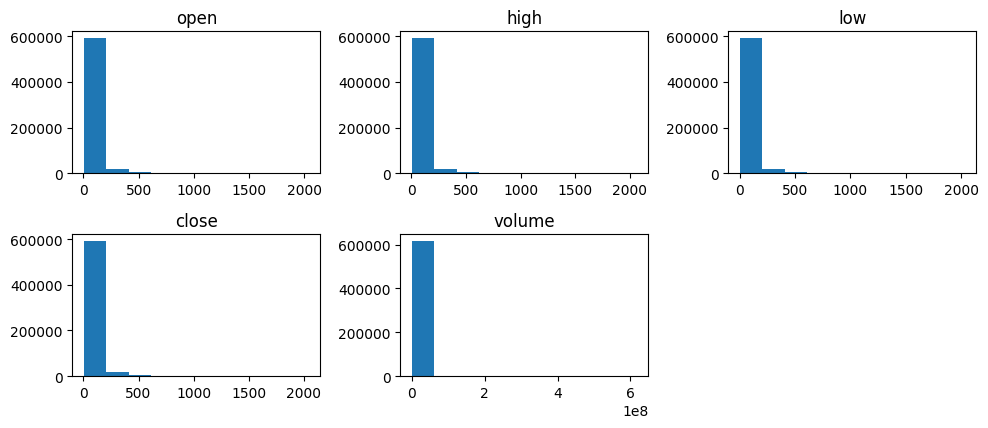

In [144]:
plt.figure(figsize=(10,6))
for i,col in enumerate(stock_data_numeric.columns):
    plt.subplot(3, 3, i+1)
    plt.hist(stock_data[col])
    plt.title(col)
plt.tight_layout()
plt.show()

In [160]:
stock_data = stock_data.ffill().bfill()

In [ ]:
stock_data.isnull().sum()

,0
date,0
open,0
high,0
low,0
close,0
volume,0
Name,0


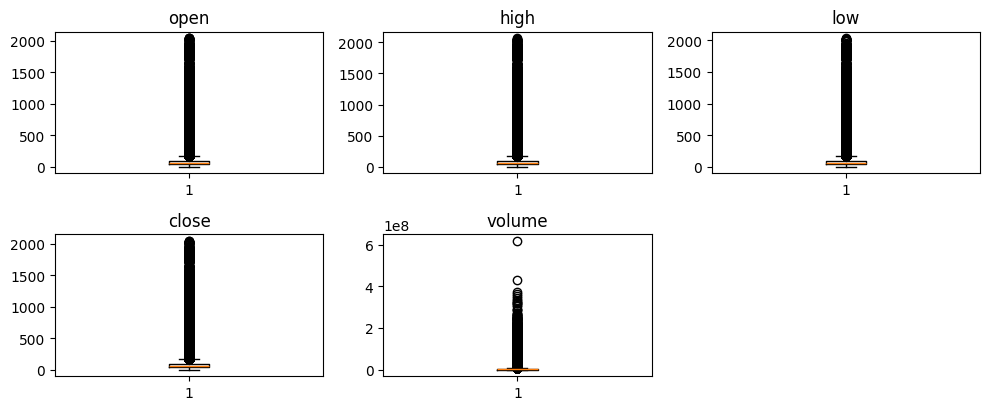

In [ ]:
plt.figure(figsize=(10,6))
for i,col in enumerate(stock_data_numeric.columns):
    plt.subplot(3, 3, i+1)
    plt.boxplot(stock_data[col])
    plt.title(col)
plt.tight_layout()
plt.show()

In [161]:
def handling_outliers(columns):
    for i in columns:
        lower_quantitle = stock_data[i].quantile(.25)
        upper_quantitle = stock_data[i].quantile(.75)

        IQR = upper_quantitle - lower_quantitle

        lower_bound = lower_quantitle-1.5*IQR
        upper_bound = upper_quantitle+1.5*IQR

        stock_data[i] = np.where(stock_data[i]<lower_bound,lower_bound,stock_data[i])
        stock_data[i] = np.where(stock_data[i]>upper_bound,upper_bound,stock_data[i])
handling_outliers(stock_data_numeric)

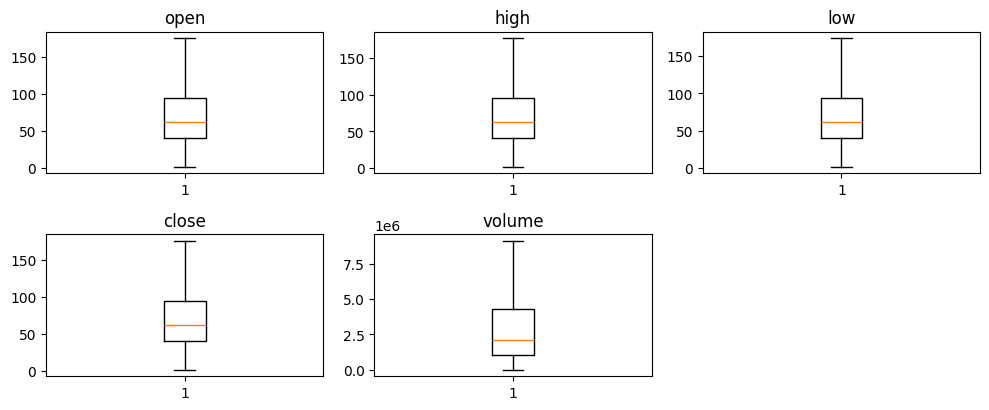

In [ ]:
def boxplotting(stock_data_numeric):
    plt.figure(figsize=(10,6))
    for i, col in enumerate(stock_data_numeric.columns):
        plt.subplot(3, 3, i+1)
        plt.boxplot(stock_data[col])
        plt.title(col)
    plt.tight_layout()
    plt.show()
boxplotting(stock_data_numeric)

            open      high       low     close    volume
open    1.000000  0.999939  0.999928  0.999872 -0.142705
high    0.999939  1.000000  0.999903  0.999936 -0.142316
low     0.999928  0.999903  1.000000  0.999939 -0.143239
close   0.999872  0.999936  0.999939  1.000000 -0.142802
volume -0.142705 -0.142316 -0.143239 -0.142802  1.000000


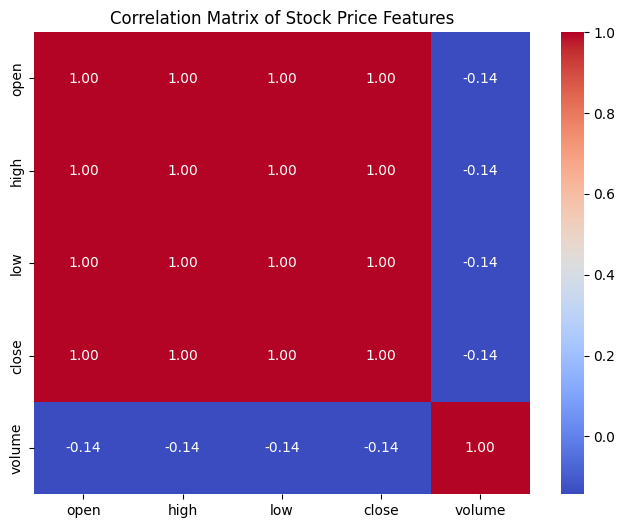

In [ ]:

# Compute Pearson correlation between numerical columns
correlation_matrix = stock_data_numeric[['open', 'high', 'low', 'close', 'volume']].corr(method='pearson')

# Display correlation matrix
print(correlation_matrix)

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Stock Price Features")
plt.show()

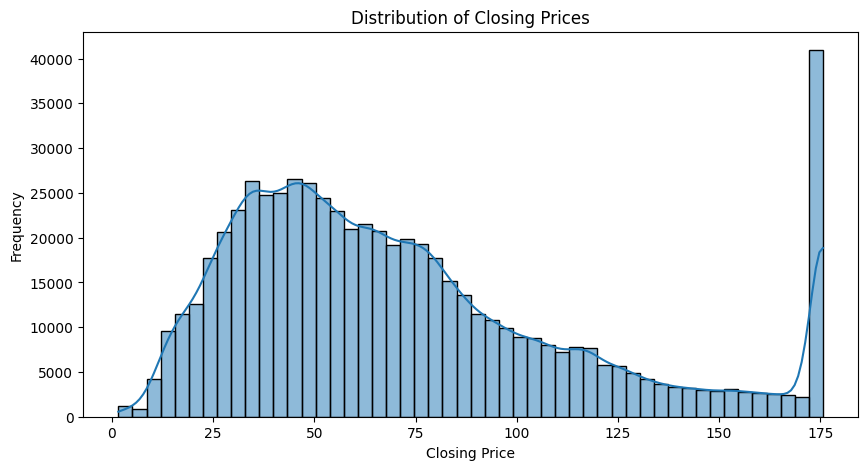

In [ ]:
# closing price distribution
plt.figure(figsize=(10, 5))
sns.histplot(stock_data['close'], bins=50, kde=True)
plt.title("Distribution of Closing Prices")
plt.xlabel("Closing Price")
plt.ylabel("Frequency")
plt.show()

In [ ]:
stock_sales = stock_data.groupby('date')['close'].sum().reset_index()
stock_sales['date'] = pd.to_datetime(stock_sales['date'])
stock_sales.set_index('date',inplace=True)
stock_sales.head()

,close
date,
2013-02-08,26361.0150
2013-02-11,26329.6075
2013-02-12,26389.0455
2013-02-13,26417.7075
2013-02-14,26399.2754


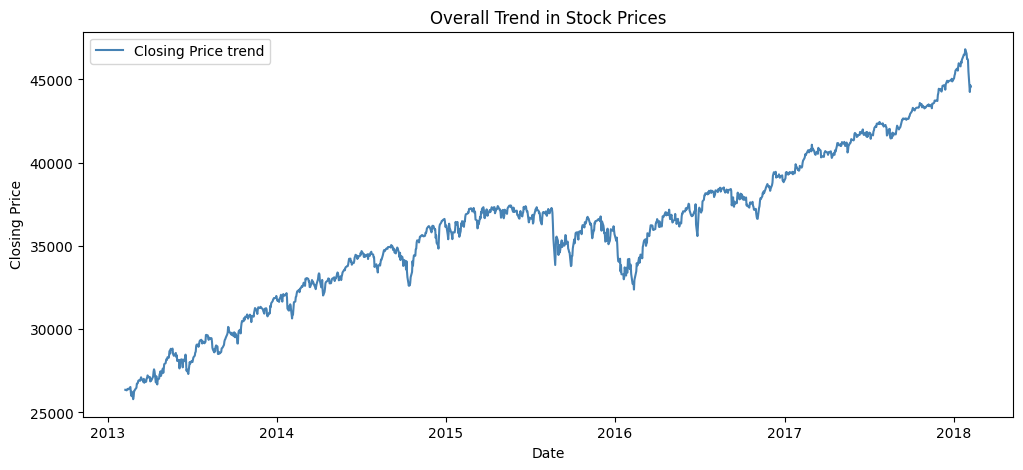

In [ ]:
# Plot overall trend in average closing prices
plt.figure(figsize=(12, 5))
plt.plot(stock_sales["close"], label="Closing Price trend", color="steelblue")
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.title("Overall Trend in Stock Prices")
plt.legend()
plt.show()

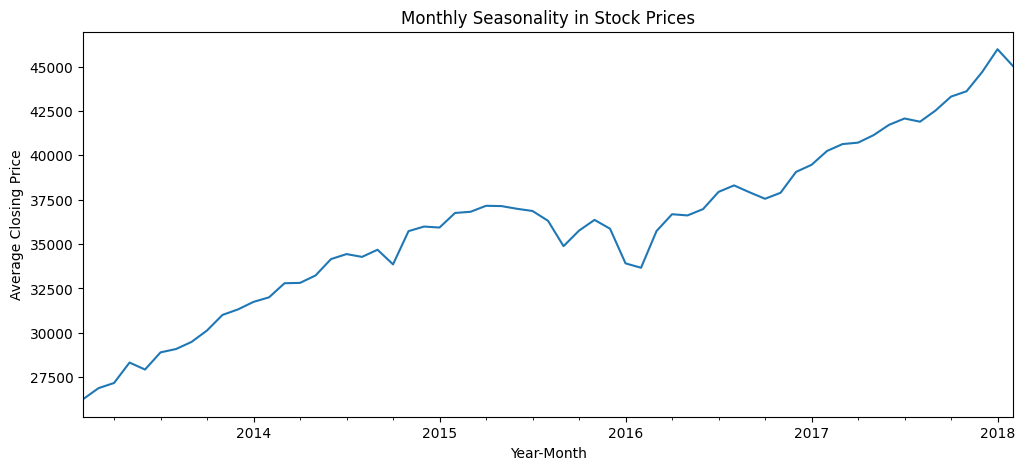

In [ ]:
# Check for seasonality by analyzing monthly average closing prices
monthly_avg = stock_sales['close'].resample('ME').mean()  # Resample by month and compute mean

# Plot seasonality pattern
plt.figure(figsize=(12, 5))
monthly_avg.plot()
plt.xlabel("Year-Month")
plt.ylabel("Average Closing Price")
plt.title("Monthly Seasonality in Stock Prices")
plt.show()

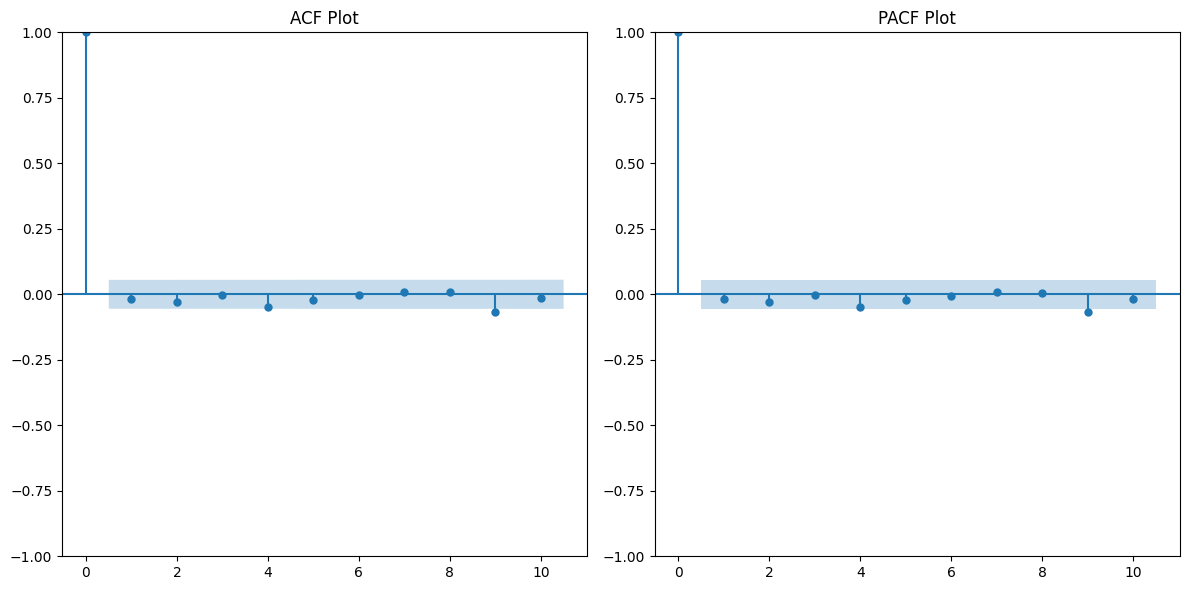

In [ ]:

# Plot ACF and PACF
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plot_acf(stock_sales['close'].diff().dropna(), lags=10, ax=plt.gca())
plt.title('ACF Plot')

plt.subplot(1, 2, 2)
plot_pacf(stock_sales['close'].diff().dropna(), lags=10, ax=plt.gca())
plt.title('PACF Plot')

plt.tight_layout()
plt.show()

#vertical- correlation
#horizontal- lags (lags in shaded region is not statistically significant)

In [162]:
# Performing the Augmented Dickey-Fuller test
def adf_test(series):
    result = adfuller(series, autolag='AIC')
    print("ADF Test Results:")
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    print("Critical Values:")
    for key, value in result[4].items():
        print(f"\t{key}: {value}")

    if result[1] < 0.05:
        print("\nConclusion: The series is stationary.")
    else:
        print("\nConclusion: The series is non-stationary.")

# Run ADF test on AirPassengers data
adf_test(stock_sales['close'])


ADF Test Results:
ADF Statistic: -1.1117356998398147
p-value: 0.710369224565724
Critical Values:
	1%: -3.4355588184378574
	5%: -2.8638402312881497
	10%: -2.5679946684494275

Conclusion: The series is non-stationary.


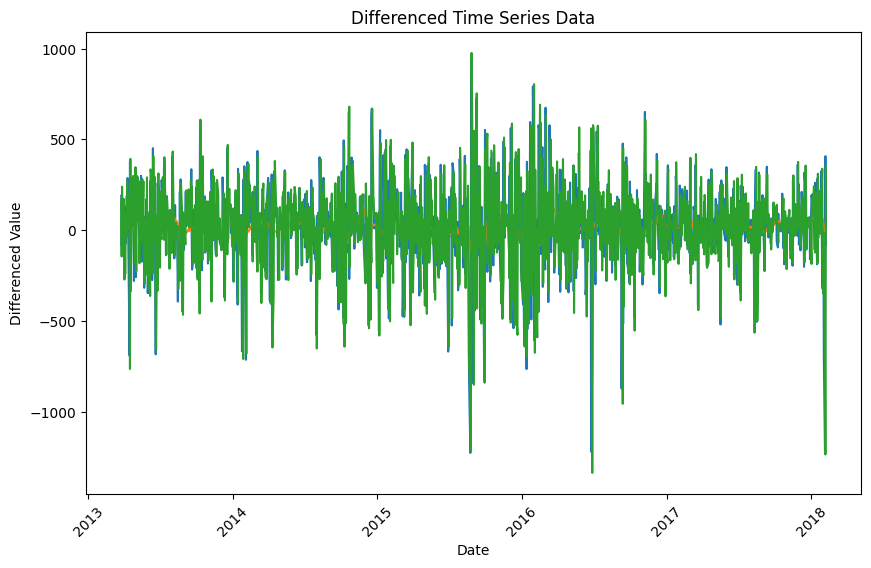

In [163]:
# Applying differencing
differenced_series =stock_sales.diff().dropna() # removes the first value (which is NaN)

# Visualize the differenced series
plt.figure(figsize=(10, 6))
plt.plot(differenced_series)
plt.title('Differenced Time Series Data')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.ylabel('Differenced Value')
plt.show()


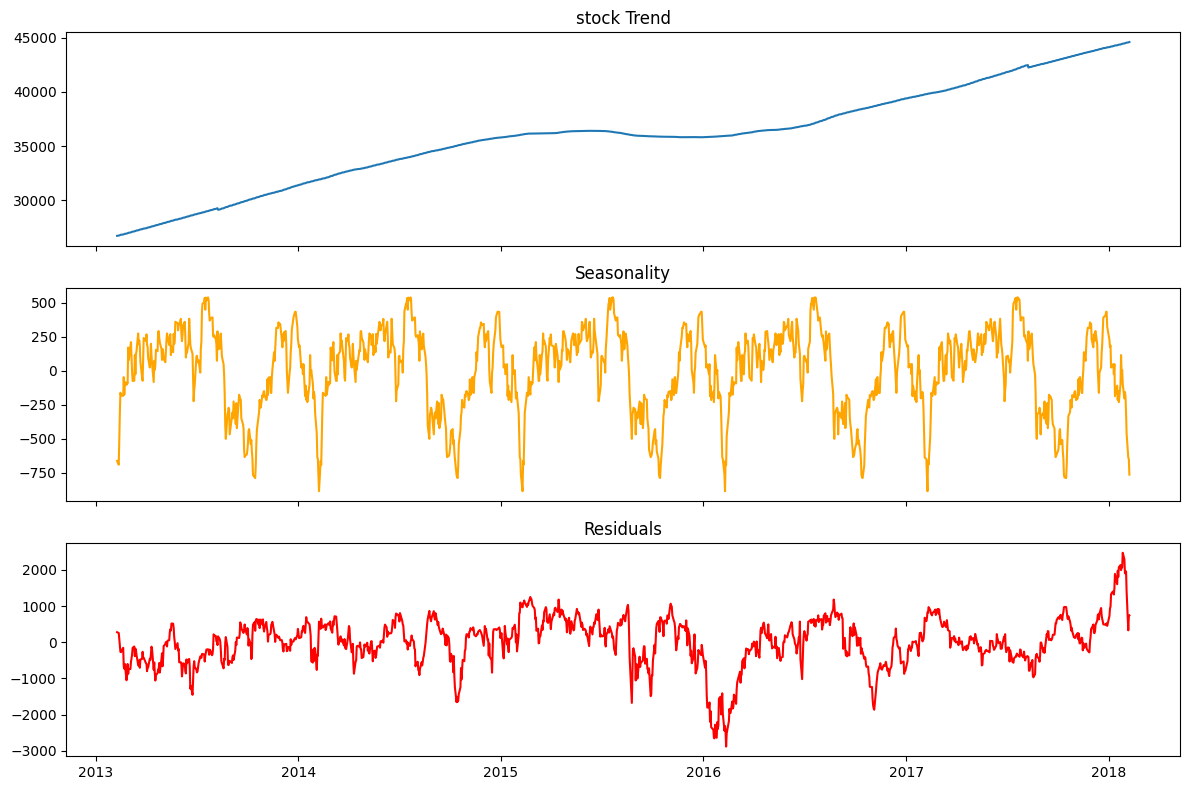

In [ ]:
# Perform decomposition on the aggregated time series
decomposition = seasonal_decompose(stock_sales['close'], period=252, model='additive', extrapolate_trend='freq')

# Plot the decomposition results
fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=True)

axes[0].plot(stock_sales.index, decomposition.trend, label="Trend")
axes[0].set_title("stock Trend")

axes[1].plot(stock_sales.index, decomposition.seasonal, label="Seasonality", color='orange')
axes[1].set_title("Seasonality")

axes[2].plot(stock_sales.index, decomposition.resid, label="Residuals", color='red')
axes[2].set_title("Residuals")

plt.tight_layout()
plt.show()


In [164]:
# Create lag features (previous day's closing price)
stock_data['lag_1'] = stock_data['close'].shift(1)
stock_data['lag_7'] = stock_data['close'].shift(7)

# Create rolling mean features
stock_data['rolling_mean_7'] = stock_data['close'].rolling(window=7).mean()
stock_data['rolling_mean_30'] = stock_data['close'].rolling(window=30).mean()

# Drop NaN values generated by shifting/rolling
stock_data.dropna(inplace=True)

# Display the first few rows
print(stock_data.head())


         date   open   high    low  close     volume Name  lag_1  lag_7  \
29 2013-03-22  17.10  17.29  16.77  16.86  8545200.0  AAL  17.00  15.91   
30 2013-03-25  16.92  17.00  16.35  16.60  8400000.0  AAL  16.86  16.25   
31 2013-03-26  16.67  16.84  16.50  16.51  6898500.0  AAL  16.60  15.98   
32 2013-03-27  16.48  16.77  16.33  16.65  5537100.0  AAL  16.51  16.29   
33 2013-03-28  17.00  17.09  16.82  16.97  8324100.0  AAL  16.65  16.78   

    rolling_mean_7  rolling_mean_30  
29       16.627143        14.769333  
30       16.677143        14.831000  
31       16.752857        14.899333  
32       16.804286        14.978667  
33       16.831429        15.055667  


In [154]:
#  sorting data by date before splitting
stock_data = stock_data.sort_index()
stock_data

,open,high,low,close,volume,Name,lag_1,lag_7,rolling_mean_7,rolling_mean_30
date,,,,,,,,,,
2013-02-08,52.69,53.25,52.660,52.86,749812.000,HOG,82.02,86.41,78.505714,82.152667
2013-02-08,59.15,59.86,59.100,59.28,2486030.000,VIAB,80.47,81.97,77.055714,77.616333
2013-02-08,93.11,93.99,92.900,93.66,1059844.000,ALXN,96.87,98.45,96.797143,100.703000
2013-02-08,68.88,69.04,68.730,69.00,8084517.000,DUK,99.27,104.24,97.538571,103.739333
2013-02-08,38.31,39.45,38.145,39.12,5104545.000,ADBE,155.15,159.70,139.835714,154.192667
...,...,...,...,...,...,...,...,...,...,...
2018-02-07,48.38,48.84,47.350,47.37,4354860.000,CHD,47.87,48.93,47.918571,49.283333
2018-02-07,64.22,66.12,64.020,65.04,9105792.375,QCOM,64.40,67.32,65.611429,66.279667
2018-02-07,20.96,21.67,20.940,21.30,4599153.000,IPG,20.98,21.76,21.385714,21.071333


In [165]:
# Defining the split index
train_size = int(len(stock_data) * 0.8)

# Splitting the data
train_stock_data = stock_data.iloc[:train_size]
test_stock_data = stock_data.iloc[train_size:]

# Display the sizes
print(f"Training Data: {train_stock_data.shape}")
print(f"Testing Data: {test_stock_data.shape}")


Training Data: (495208, 11)
Testing Data: (123803, 11)


## Statistical Forecasting

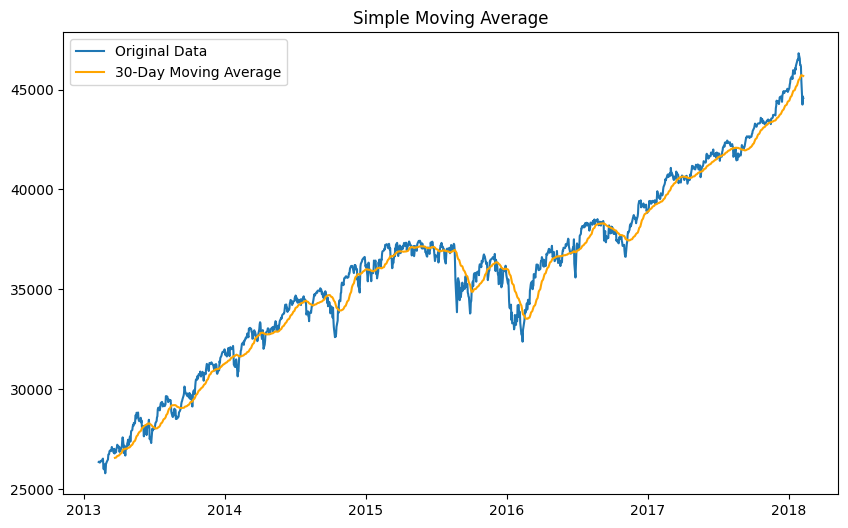

In [ ]:


# Calculate Simple Moving Average with a window of 30 days
window_size = 30
stock_sales['SMA'] = stock_sales['close'].rolling(window=window_size).mean()

# Plot original data and moving average
plt.figure(figsize=(10, 6))
plt.plot(stock_sales['close'], label='Original Data')
plt.plot(stock_sales['SMA'], label=f'{window_size}-Day Moving Average', color='orange')
plt.legend()
plt.title('Simple Moving Average')
plt.show()


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


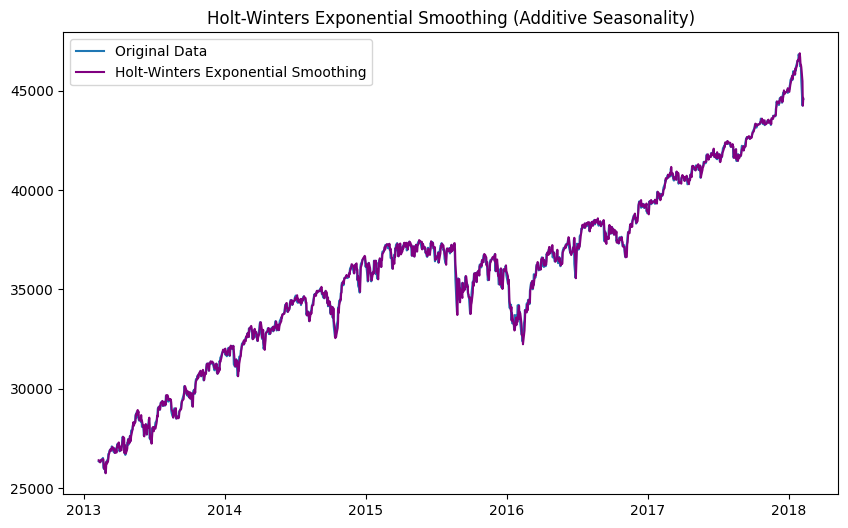

In [ ]:
'''Holt-Winters is an extension of SES that can model data with both trend and seasonality.
It has three components: level, trend, and seasonality.
The method adjusts the level and trend over time while also adjusting for seasonal patterns.'''


# Applying Holt-Winters Exponential Smoothing (Additive Seasonality)
hw_model = ExponentialSmoothing(stock_sales['close'], trend='add', seasonal='add', seasonal_periods=7).fit()

# Get the fitted values
stock_sales['Holt-Winters'] = hw_model.fittedvalues

# Plot original data and Holt-Winters
plt.figure(figsize=(10, 6))
plt.plot(stock_sales['close'], label='Original Data')
plt.plot(stock_sales['Holt-Winters'], label='Holt-Winters Exponential Smoothing', color='purple')
plt.legend()
plt.title('Holt-Winters Exponential Smoothing (Additive Seasonality)')
plt.show()


In [ ]:
# Set grid search range
p = q = range(0, 5)
d = [1]
pdq = list(itertools.product(p, d, q))

# Store results
best_aic = float("inf")
best_order = None
best_model = None

print("Starting ARIMA Grid Search...")

for order in pdq:
    try:
        model = sm.tsa.ARIMA(differenced_series['close'], order=order)
        results = model.fit()
        if results.aic < best_aic:
            best_aic = results.aic
            best_order = order
            best_model = results
        print(f"ARIMA{order} AIC: {results.aic:.2f}")
    except:
        continue

print("\nBest ARIMA order:", best_order)
print("Best AIC:", best_aic)



Starting ARIMA Grid Search...
ARIMA(0, 1, 0) AIC: 18159.21
ARIMA(0, 1, 1) AIC: 17275.87
ARIMA(0, 1, 2) AIC: 17277.46
ARIMA(0, 1, 3) AIC: 17278.35
ARIMA(0, 1, 4) AIC: 17280.93
ARIMA(1, 1, 0) AIC: 17809.18
ARIMA(1, 1, 1) AIC: 17277.57
ARIMA(1, 1, 2) AIC: 17277.73
ARIMA(1, 1, 3) AIC: 17279.12
ARIMA(1, 1, 4) AIC: 17282.32
ARIMA(2, 1, 0) AIC: 17647.87
ARIMA(2, 1, 1) AIC: 17278.46
ARIMA(2, 1, 2) AIC: 17280.15
ARIMA(2, 1, 3) AIC: 17280.49
ARIMA(2, 1, 4) AIC: 17274.20
ARIMA(3, 1, 0) AIC: 17583.44
ARIMA(3, 1, 1) AIC: 17280.45
ARIMA(3, 1, 2) AIC: 17282.45
ARIMA(3, 1, 3) AIC: 17281.29
ARIMA(3, 1, 4) AIC: 17273.84
ARIMA(4, 1, 0) AIC: 17530.26
ARIMA(4, 1, 1) AIC: 17279.45
ARIMA(4, 1, 2) AIC: 17284.45
ARIMA(4, 1, 3) AIC: 17283.33
ARIMA(4, 1, 4) AIC: 17281.23

Best ARIMA order: (3, 1, 4)
Best AIC: 17273.83616341199


In [ ]:
#Aggregate duplicates (average close price per day)
train_stock_data = train_stock_data.groupby('date').agg({'close': 'mean'}).reset_index()

train_stock_data.set_index('date', inplace=True)
train_stock_data = train_stock_data.asfreq('B')

train_stock_data['close'] = train_stock_data['close'].ffill().bfill()

model = sm.tsa.ARIMA(train_stock_data['close'], order=(3, 1, 4))
results = model.fit()

print(results.summary())


                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                 1304
Model:                 ARIMA(3, 1, 4)   Log Likelihood                -810.417
Date:                Thu, 17 Apr 2025   AIC                           1636.833
Time:                        07:48:59   BIC                           1678.213
Sample:                    02-08-2013   HQIC                          1652.357
                         - 02-07-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0132      0.091      0.145      0.885      -0.166       0.192
ar.L2         -0.1049      0.083     -1.261      0.207      -0.268       0.058
ar.L3          0.9095      0.092      9.840      0.0

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
steps=30
forecast_values = results.forecast(steps=steps)
forecast_values.head()

,predicted_mean
2018-02-08,87.536267
2018-02-09,87.589523
2018-02-12,87.566344
2018-02-13,87.587945
2018-02-14,87.639097


In [ ]:
# Actual values (replace with the true values corresponding to forecast)
actual_values = stock_sales['close'].iloc[-30:].values

# RMSE (Root Mean Squared Error)
rmse = np.sqrt(mean_squared_error(actual_values, forecast_values))
print(f"RMSE: {rmse}")

# MAE (Mean Absolute Error)
mae = mean_absolute_error(actual_values, forecast_values)
print(f"MAE: {mae}")

# MAPE (Mean Absolute Percentage Error)
mape = np.mean(np.abs((actual_values - forecast_values) / actual_values)) * 100
print(f"MAPE: {mape}%")

# MSE (Mean Squared Error)
mse = mean_squared_error(actual_values, forecast_values)
print(f"MSE: {mse}")

# R² (R-squared)
r2 = r2_score(actual_values, forecast_values)
print(f"R²: {r2}")




RMSE: 45599.36344914068
MAE: 45594.54923221229
MAPE: 99.80795845118664%
MSE: 2079301946.966827
R²: -4734.720042954299


<ipython-input-35-25301f10f484>:16: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  company_data['close'] = company_data['close'].fillna(method='ffill')
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


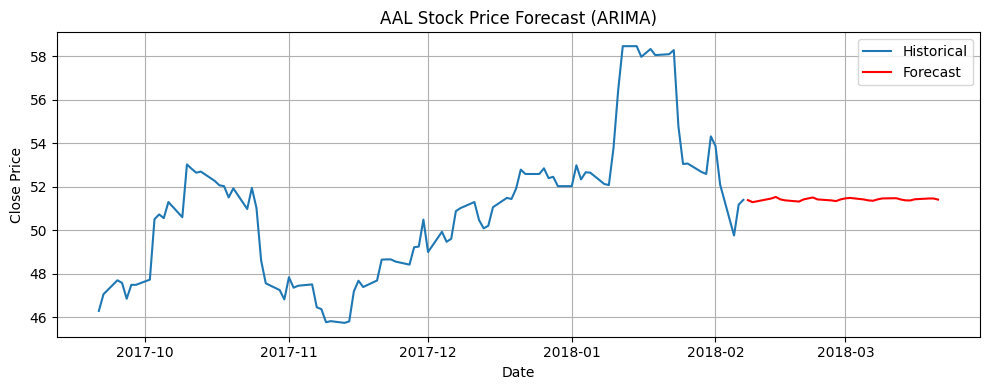

<ipython-input-35-25301f10f484>:16: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  company_data['close'] = company_data['close'].fillna(method='ffill')
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


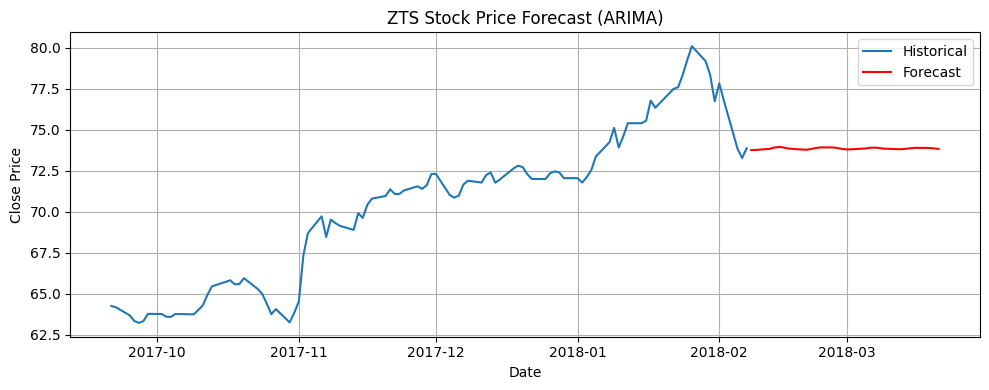

In [ ]:
# Filter for selected companies
companies = ['AAL', 'ZTS']
forecast_horizon = 30

# Dictionary to store forecasts
arima_forecasts = {}

# Prepare and forecast using ARIMA
for company in companies:
    company_data = stock_data[stock_data['Name'] == company].copy()
    company_data['date'] = pd.to_datetime(company_data['date'])
    company_data.set_index('date', inplace=True)

    # Ensure business-day frequency and fill missing values (important for ARIMA)
    company_data = company_data.asfreq('B')
    company_data['close'] = company_data['close'].fillna(method='ffill')

    close_prices = company_data['close']

    # Fit ARIMA model
    model = ARIMA(close_prices, order=(3, 1, 4))
    model_fit = model.fit()

    # Forecast
    forecast = model_fit.forecast(steps=forecast_horizon)

    # Create forecast date index
    last_date = close_prices.index[-1]
    forecast_index = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=forecast_horizon, freq='B')
    forecast = pd.Series(forecast, index=forecast_index)

    # Store forecast
    arima_forecasts[company] = forecast

    # Plot
    plt.figure(figsize=(10, 4))
    plt.plot(close_prices[-100:], label='Historical')
    plt.plot(forecast.index, forecast, label='Forecast', color='red')
    plt.title(f"{company} Stock Price Forecast (ARIMA)")
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


## Machine Learning Forecasting

In [169]:
stock_data['date'] = pd.to_datetime(stock_data['date'])
stock_data.set_index('date', inplace=True)
stock_data.head()

,open,high,low,close,volume,Name,lag_1,lag_7,rolling_mean_7,rolling_mean_30
date,,,,,,,,,,
2013-03-22,17.10,17.29,16.77,16.86,8545200.0,AAL,17.00,15.91,16.627143,14.769333
2013-03-25,16.92,17.00,16.35,16.60,8400000.0,AAL,16.86,16.25,16.677143,14.831000
2013-03-26,16.67,16.84,16.50,16.51,6898500.0,AAL,16.60,15.98,16.752857,14.899333
2013-03-27,16.48,16.77,16.33,16.65,5537100.0,AAL,16.51,16.29,16.804286,14.978667
2013-03-28,17.00,17.09,16.82,16.97,8324100.0,AAL,16.65,16.78,16.831429,15.055667


In [170]:
stock_data['month'] = stock_data.index.month
stock_data["day_of_week"] = stock_data.index.dayofweek

# Get US Federal Holidays
cal = USFederalHolidayCalendar()
holidays = cal.holidays(start=stock_data.index.min(), end=stock_data.index.max())

# Mark if the date is a holiday
stock_data["is_holiday"] = stock_data.index.isin(holidays).astype(int)
print(stock_data.head())


             open   high    low  close     volume Name  lag_1  lag_7  \
date                                                                   
2013-03-22  17.10  17.29  16.77  16.86  8545200.0  AAL  17.00  15.91   
2013-03-25  16.92  17.00  16.35  16.60  8400000.0  AAL  16.86  16.25   
2013-03-26  16.67  16.84  16.50  16.51  6898500.0  AAL  16.60  15.98   
2013-03-27  16.48  16.77  16.33  16.65  5537100.0  AAL  16.51  16.29   
2013-03-28  17.00  17.09  16.82  16.97  8324100.0  AAL  16.65  16.78   

            rolling_mean_7  rolling_mean_30  month  day_of_week  is_holiday  
date                                                                         
2013-03-22       16.627143        14.769333      3            4           0  
2013-03-25       16.677143        14.831000      3            0           0  
2013-03-26       16.752857        14.899333      3            1           0  
2013-03-27       16.804286        14.978667      3            2           0  
2013-03-28       16.831429 

In [171]:
def create_lagged_features(stock_data, target_col="close", lags=8):
    for i in range(1, lags+1):
        stock_data[f"lag_{i}"] = stock_data[target_col].shift(i)
    return stock_data

stock_data = create_lagged_features(stock_data, target_col="close", lags=10)
stock_data.dropna(inplace=True)
print(stock_data.head())


             open   high    low  close     volume Name  lag_1  lag_7  \
date                                                                   
2013-04-08  15.82  15.97  15.53  15.84  3780700.0  AAL  15.72  16.65   
2013-04-09  16.07  16.10  15.67  15.70  4420200.0  AAL  15.84  16.97   
2013-04-10  15.74  15.98  15.70  15.78  3650600.0  AAL  15.70  16.67   
2013-04-11  15.77  16.38  15.75  16.19  5062200.0  AAL  15.78  15.74   
2013-04-12  16.11  16.39  15.95  16.14  3751800.0  AAL  16.19  15.53   

            rolling_mean_7  rolling_mean_30  ...  day_of_week  is_holiday  \
date                                         ...                            
2013-04-08       16.022857        15.461333  ...            0           0   
2013-04-09       15.841429        15.550667  ...            1           0   
2013-04-10       15.714286        15.634667  ...            2           0   
2013-04-11       15.778571        15.727333  ...            3           0   
2013-04-12       15.865714       

In [172]:

stock_data["rolling_std_7"] = stock_data["close"].rolling(window=7).std()
stock_data.dropna(inplace=True)
print(stock_data.head())


             open   high    low  close       volume Name  lag_1  lag_7  \
date                                                                     
2013-04-16  15.96  16.74  15.81  16.37  9105792.375  AAL  15.59  15.72   
2013-04-17  16.17  16.55  15.90  16.52  6581900.000  AAL  16.37  15.84   
2013-04-18  16.54  16.54  15.95  16.10  7633300.000  AAL  16.52  15.70   
2013-04-19  16.10  16.24  15.85  16.02  5762600.000  AAL  16.10  15.78   
2013-04-22  15.99  16.00  15.50  15.52  9105792.375  AAL  16.02  16.19   

            rolling_mean_7  rolling_mean_30  ...  is_holiday  lag_2  lag_3  \
date                                         ...                             
2013-04-16       15.944286        15.966000  ...           0  16.14  16.19   
2013-04-17       16.041429        16.048333  ...           0  15.59  16.14   
2013-04-18       16.098571        16.099333  ...           0  16.37  15.59   
2013-04-19       16.132857        16.139333  ...           0  16.52  16.37   
2013-04-22   

  ##### Preparing data

In [173]:
''''Why Use random_state=42?
 If you are sharing code with others or revisiting your analysis,
using a fixed random_state ensures that the training and test sets remain the same.
This is especially important for comparing results or debugging.'''

# Make sure all relevant features are included and numeric
X = stock_data.drop(columns=["Name", "close"], errors="ignore")
y = stock_data["close"]

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale ALL features together
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Save correctly trained scaler
joblib.dump(scaler, "scaler.pkl")

X_test_scaled = scaler.transform(X_test)


##### Train Linear Regression

In [174]:
# Train Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

# Make predictions
lr_predictions = lr_model.predict(X_test_scaled)

# Evaluate model
lr_mae = mean_absolute_error(y_test, lr_predictions)
lr_rmse = np.sqrt(mean_squared_error(y_test, lr_predictions))
lr_r2 = r2_score(y_test, lr_predictions)
# MSE (Mean Squared Error)
lr_mse = mean_squared_error(y_test, lr_predictions)



print(f"Linear Regression -> MAE: {lr_mae}, RMSE: {lr_rmse}, R²: {lr_r2}, MSE: {lr_mse}")


Linear Regression -> MAE: 1.1861491002127784e-13, RMSE: 1.4843098272743506e-13, R²: 1.0, MSE: 2.2031756633432124e-26


##### Train Random Forest

In [183]:
# Train Random Forest model
rf_model = RandomForestRegressor(n_estimators=20, max_depth=5, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
rf_predictions = rf_model.predict(X_test)

# Evaluate model
rf_mae = mean_absolute_error(y_test, rf_predictions)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_predictions))
rf_r2 = r2_score(y_test, rf_predictions)
rf_mse = mean_squared_error(y_test, rf_predictions)

print(f"Random Forest -> MAE: {rf_mae}, RMSE: {rf_rmse}, R²: {rf_r2}, MSE: {rf_mse}")


Random Forest -> MAE: 1.1497014127811986, RMSE: 1.4435136726835975, R²: 0.9989037300918162, MSE: 2.0837317232244885


##### Hyperparameter Tuning of Linear regression and Random forest

  Linear Regression

In [ ]:
# Define parameter grid
ridge_params = {"alpha": [0.01, 0.1, 1, 10, 100]}

# Perform Grid Search
ridge_grid = GridSearchCV(Ridge(), ridge_params, cv=5, scoring="neg_mean_squared_error")
ridge_grid.fit(X_train_scaled, y_train)

# Get best model
best_ridge = ridge_grid.best_estimator_

# Evaluate model
ridge_predictions = best_ridge.predict(X_test_scaled)
ridge_rmse = np.sqrt(mean_squared_error(y_test, ridge_predictions))
ridge_r2 = r2_score(y_test, ridge_predictions)
ridge_mse = mean_squared_error(y_test, ridge_predictions)

print(f"Best Ridge Regression -> Alpha: {ridge_grid.best_params_['alpha']},MSE: {ridge_mse}, RMSE: {ridge_rmse}, R²: {ridge_r2}")


Best Ridge Regression -> Alpha: 0.01, RMSE: 0.0051634128856317815, R²: 0.9999999860051897


   Random Forest

In [ ]:
#reshaping the data to 2d .values to convert them to NumPy arrays.
X_train_2d = X_train.values.reshape(X_train.shape[0], -1)
X_test_2d = X_test.values.reshape(X_test.shape[0], -1)

# Simplified parameter grid for faster execution/tuning
rf_params = {
    'n_estimators': [50],        #Number of decision trees in the forest. More trees = better generalization (usually) but slower.
    'max_depth': [10],            #Maximum depth of each tree. Lower depth helps avoid overfitting.
    'min_samples_split': [2]       #Minimum number of samples required to split an internal node. Larger values prevent the model from learning overly specific rules.
}

# Grid search with with cross validation
rf_grid = GridSearchCV(
    RandomForestRegressor(random_state=42),
    rf_params,
    cv=3,                              #3-fold cross-validation. The training set is split into 3 parts; the model trains on 2 and validates on the 3rd.
    scoring="neg_mean_squared_error",
    n_jobs=-1,
    verbose=2
)

# Fit model
rf_grid.fit(X_train_2d, y_train)

# Best estimator from grid search
best_rf = rf_grid.best_estimator_

# Predictions and evaluation
rf_predictions = best_rf.predict(X_test_2d)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_predictions))
rf_r2 = r2_score(y_test, rf_predictions)

print(f"Best Random Forest -> Params: {rf_grid.best_params_}, RMSE: {rf_rmse:.4f}, R²: {rf_r2:.4f}")


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best Random Forest -> Params: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 50}, RMSE: 0.9081, R²: 0.9999


 Comparing  ML models to ARIMA/SARIMA

## Deep Learning for Time Series

In [ ]:

# Prepare data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(stock_data[['close']])

# Create sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 3
X, y = create_sequences(scaled_data, seq_length)

# Train/Test split
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


In [ ]:
# Function to create sequences for LSTM input
def create_lstm_dataset(data, look_back=60):
    X, y = [], []
    for i in range(look_back, len(data)):
        X.append(data[i-look_back:i, 0])  # Sequence of previous 'look_back' steps
        y.append(data[i, 0])              # The target is the next time step value
    return np.array(X), np.array(y)

# Assuming 'stock_data' has a 'Close' column
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(stock_data['close'].values.reshape(-1, 1))

# Create dataset
X, y = create_lstm_dataset(scaled_data, look_back=60)

# Split data into training and test sets (80-20 split)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape data for LSTM (3D input)
X_train_reshaped = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test_reshaped = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

Epoch 1/5
4952/4952 ━━━━━━━━━━━━━━━━━━━━ 226s 45ms/step - loss: 0.0019
Epoch 2/5
4952/4952 ━━━━━━━━━━━━━━━━━━━━ 265s 46ms/step - loss: 1.7825e-04
Epoch 3/5
4952/4952 ━━━━━━━━━━━━━━━━━━━━ 263s 53ms/step - loss: 2.0029e-04
Epoch 4/5
4952/4952 ━━━━━━━━━━━━━━━━━━━━ 346s 58ms/step - loss: 1.8555e-04
Epoch 5/5
4952/4952 ━━━━━━━━━━━━━━━━━━━━ 232s 47ms/step - loss: 1.6872e-04
3869/3869 ━━━━━━━━━━━━━━━━━━━━ 35s 9ms/step


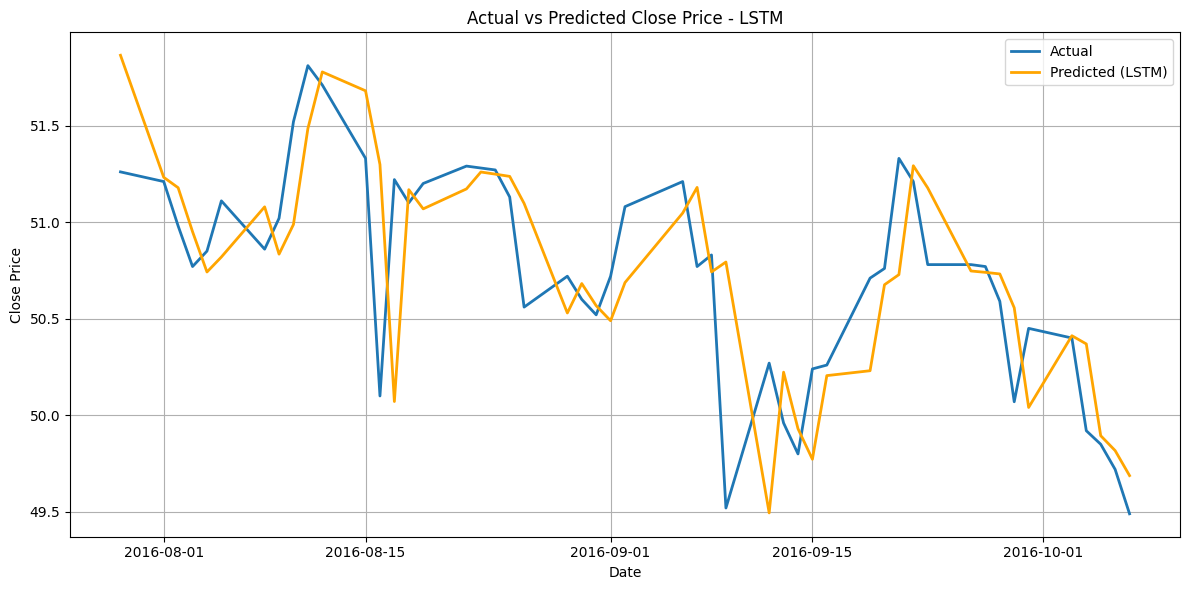

In [ ]:


# Define LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=False, input_shape=(X_train_reshaped.shape[1], 1)))
model.add(Dense(units=1))  # Output layer

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train_reshaped, y_train, epochs=5, batch_size=100)

# Make predictions
lstm_predictions = model.predict(X_test_reshaped)

# Ensure y_test is reshaped properly for inverse_transform
y_test_reshaped = y_test.reshape(-1, 1)

# Inverse scale both y_test and predictions
y_test_inverse = scaler.inverse_transform(y_test_reshaped)
lstm_predictions_inverse = scaler.inverse_transform(lstm_predictions)

# Plot only a subset if the data is too long
num_points_to_plot = 50  # you can increase or decrease for clarity

plt.figure(figsize=(12, 6))
plt.plot(
    stock_data.index[-len(y_test):-len(y_test)+num_points_to_plot],
    y_test_inverse[:num_points_to_plot],
    label='Actual', linewidth=2
)
plt.plot(
    stock_data.index[-len(y_test):-len(y_test)+num_points_to_plot],
    lstm_predictions_inverse[:num_points_to_plot],
    label='Predicted (LSTM)', linewidth=2, color='orange'
)
plt.legend()
plt.title('Actual vs Predicted Close Price - LSTM')
plt.ylabel('Close Price')
plt.xlabel('Date')
plt.grid(True)
plt.tight_layout()
plt.show()


#### Compare LSTM results with ML & ARIMA models

In [ ]:
# RMSE (Root Mean Squared Error)
lstm_rmse = np.sqrt(mean_squared_error(y_test_inverse, lstm_predictions_inverse))
print(f"LSTM Model -> RMSE: {lstm_rmse}")

# MAE (Mean Absolute Error)
lstm_mae = mean_absolute_error(y_test_inverse, lstm_predictions_inverse)
print(f"LSTM Model -> MAE: {lstm_mae}")

# MSE (Mean Squared Error)
lstm_mse = mean_squared_error(y_test_inverse, lstm_predictions_inverse)
print(f"LSTM Model -> MSE: {lstm_mse}")

# R² (R-squared)
lstm_r2 = r2_score(y_test_inverse, lstm_predictions_inverse)
print(f"LSTM Model -> R²: {lstm_r2}")


LSTM Model -> RMSE: 2.1784532147133233
LSTM Model -> MAE: 0.7413269919629698
LSTM Model -> MSE: 4.745658408694813
LSTM Model -> R²: 0.9968799041898111


## Best model deploy

In [246]:
!pkill streamlit
from pyngrok import ngrok
ngrok.kill()


In [95]:
!pip install streamlit pyngrok --quiet


In [250]:
import joblib

# Save the Random Forest model
joblib.dump(rf_model, "rf_model.pkl")

# Save the fitted scaler
joblib.dump(scaler, "scaler.pkl")



['scaler.pkl']

In [251]:
%%writefile streamlit_app.py
import streamlit as st
import pandas as pd
import numpy as np
import joblib

# Load model and scaler
model = joblib.load("rf_model.pkl")
scaler = joblib.load("scaler.pkl")

st.set_page_config(page_title="Stock Price Predictor (Random forest)", layout="centered")
st.title("📈 Stock Price Prediction using Random forest")
st.markdown("Enter feature values to predict the stock's closing price.")

# Replace with actual feature names from your dataset
feature_names = ['open', 'high', 'low','volume','lag_1','lag_7','rolling_mean_7','rolling_mean_30','month','day_of_week',
                 'is_holiday','lag_2', 'lag_3', 'lag_4','lag_5','lag_6', 'lag_8',
                 'lag_9',  'lag_10', 'rolling_std_7']

# UI inputs
input_data = {}
cols = st.columns(3)
for i, feature in enumerate(feature_names):
    with cols[i % 3]:
        input_data[feature] = st.number_input(f"{feature}", value=0.0)

# Prepare input for prediction
input_df = pd.DataFrame([input_data])[feature_names]
input_scaled = scaler.transform(input_df)


if st.button("🔮 Predict Closing Price"):
    prediction = model.predict(input_scaled)[0]
    st.success(f"📊 Predicted Close Price: **${prediction:.2f}**")


Overwriting streamlit_app.py


In [252]:
from pyngrok import ngrok

# Paste your token in the string below:
NGROK_AUTH_TOKEN = "2vo5Fxumho4plWFGt9qjNGvo8Se_7LV4KjLYG1Z7x3Fb55WC3"
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

In [253]:
!streamlit run streamlit_app.py &>/content/logs.txt &
import time
time.sleep(5)  # Give it time to spin up
from pyngrok import ngrok
ngrok.set_auth_token("2vo5Fxumho4plWFGt9qjNGvo8Se_7LV4KjLYG1Z7x3Fb55WC3")
public_url = ngrok.connect(8501)
print(f"✅ Your app is live at: {public_url}")



✅ Your app is live at: NgrokTunnel: "https://77cd-34-122-53-96.ngrok-free.app" -> "http://localhost:8501"


In [193]:
from pyngrok import ngrok

tunnels = ngrok.get_tunnels()
for tunnel in tunnels:
    print(tunnel.public_url)

In [192]:
# Disconnect existing tunnels (replace with actual tunnel URLs if known)
ngrok.disconnect("https://e8a0-34-122-53-96.ngrok-free.app") # Replace with your existing tunnel URL


# Using power consumption data

In [196]:
from google.colab import files
uploaded = files.upload()


Saving household_power_consumption.txt to household_power_consumption.txt


## Data exploration and processing

In [197]:
power_data = pd.read_csv('household_power_consumption.txt', sep=';', low_memory=False)
power_data.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [198]:
# Combine Date and Time into a single datetime column
power_data['Datetime'] = pd.to_datetime(power_data['Date'] + ' ' + power_data['Time'], errors='coerce')


<ipython-input-198-8cb117712c39>:2: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  power_data['Datetime'] = pd.to_datetime(power_data['Date'] + ' ' + power_data['Time'], errors='coerce')


In [199]:
# Drop original columns and set datetime as index
power_data.drop(['Date', 'Time'], axis=1, inplace=True)
power_data.set_index('Datetime', inplace=True)
power_data.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Datetime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
2006-12-16 17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2006-12-16 17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
2006-12-16 17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
2006-12-16 17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [200]:
# Convert numeric columns to float (they may be read as object due to bad values)
for col in power_data.columns:
    power_data[col] = pd.to_numeric(power_data[col], errors='coerce')

# Sort by datetime
power_data.sort_index(inplace=True)

In [ ]:
power_data.shape

(2075259, 7)

In [ ]:
power_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    float64
 1   Global_reactive_power  float64
 2   Voltage                float64
 3   Global_intensity       float64
 4   Sub_metering_1         float64
 5   Sub_metering_2         float64
 6   Sub_metering_3         float64
dtypes: float64(7)
memory usage: 126.7 MB


In [ ]:
power_data.describe()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
count,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06
mean,1.091615e+00,1.237145e-01,2.408399e+02,4.627759e+00,1.121923e+00,1.298520e+00,6.458447e+00
std,1.057294e+00,1.127220e-01,3.239987e+00,4.444396e+00,6.153031e+00,5.822026e+00,8.437154e+00
min,7.600000e-02,0.000000e+00,2.232000e+02,2.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.080000e-01,4.800000e-02,2.389900e+02,1.400000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,6.020000e-01,1.000000e-01,2.410100e+02,2.600000e+00,0.000000e+00,0.000000e+00,1.000000e+00
75%,1.528000e+00,1.940000e-01,2.428900e+02,6.400000e+00,0.000000e+00,1.000000e+00,1.700000e+01
max,1.112200e+01,1.390000e+00,2.541500e+02,4.840000e+01,8.800000e+01,8.000000e+01,3.100000e+01


In [ ]:
power_data.dtypes

,0
Global_active_power,float64
Global_reactive_power,float64
Voltage,float64
Global_intensity,float64
Sub_metering_1,float64
Sub_metering_2,float64
Sub_metering_3,float64


In [ ]:
power_data.isnull().sum()

,0
Global_active_power,25979
Global_reactive_power,25979
Voltage,25979
Global_intensity,25979
Sub_metering_1,25979
Sub_metering_2,25979
Sub_metering_3,25979


In [201]:
power_data_numeric = power_data.select_dtypes(include=['float64', 'int64'])
power_data_numeric.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Datetime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


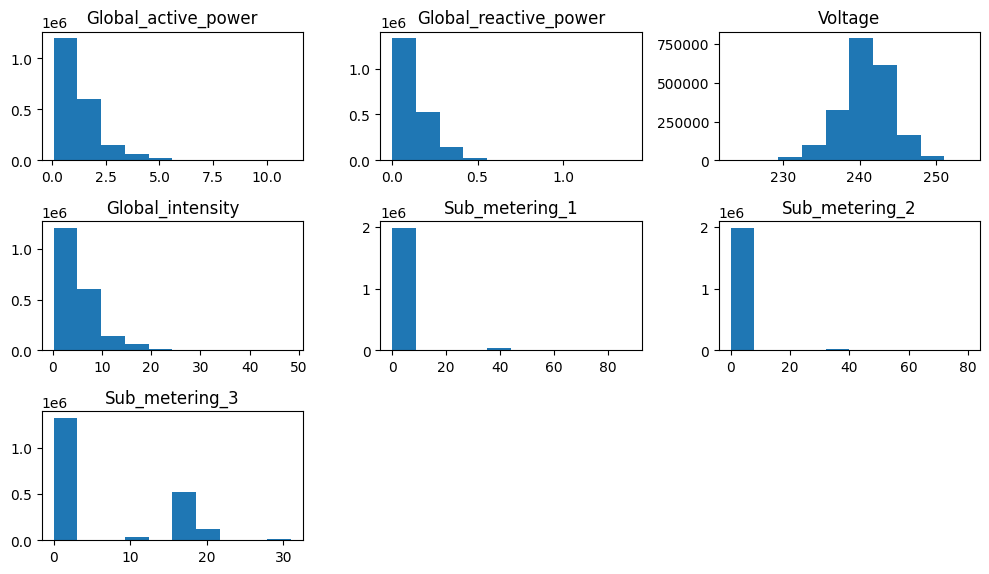

In [202]:
plt.figure(figsize=(10,6))
for i,col in enumerate(power_data_numeric.columns):
    plt.subplot(3, 3, i+1)
    plt.hist(power_data[col])
    plt.title(col)
plt.tight_layout()
plt.show()

In [203]:

# Handle missing values
power_data = power_data.fillna(method='ffill').fillna(method='bfill')

<ipython-input-203-e17c2fbe3bf2>:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  power_data = power_data.fillna(method='ffill').fillna(method='bfill')


In [ ]:
power_data.isnull().sum()

,0
Global_active_power,0
Global_reactive_power,0
Voltage,0
Global_intensity,0
Sub_metering_1,0
Sub_metering_2,0
Sub_metering_3,0


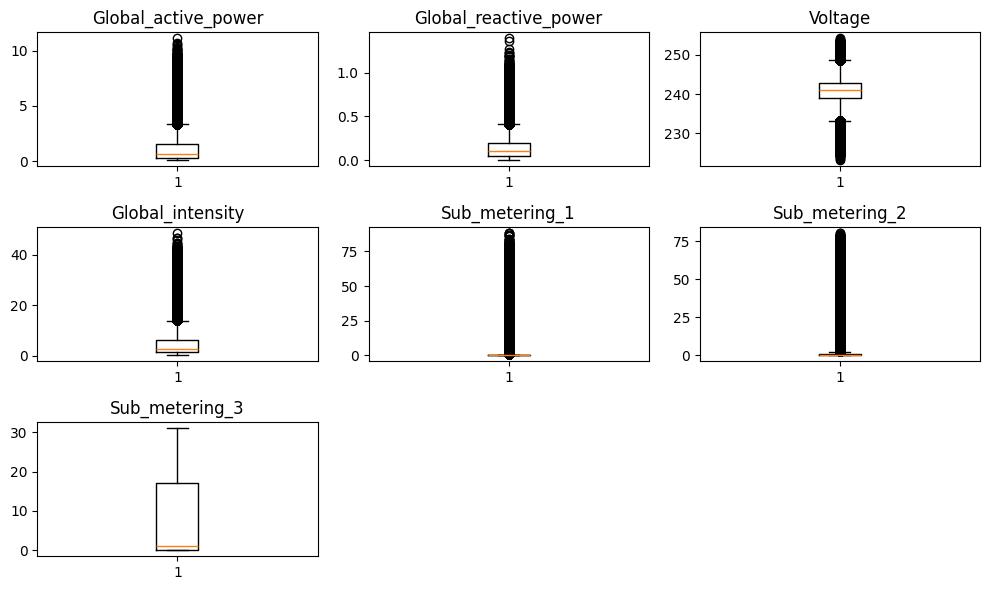

In [ ]:
plt.figure(figsize=(10,6))
for i,col in enumerate(power_data_numeric.columns):
    plt.subplot(3, 3, i+1)
    plt.boxplot(power_data[col])
    plt.title(col)
plt.tight_layout()
plt.show()

In [204]:
def handling_outliers(columns):
    for i in columns:
        lower_quantitle = power_data[i].quantile(.25)
        upper_quantitle = power_data[i].quantile(.75)

        IQR = upper_quantitle - lower_quantitle

        lower_bound = lower_quantitle-1.5*IQR
        upper_bound = upper_quantitle+1.5*IQR

        power_data[i] = np.where(power_data[i]<lower_bound,lower_bound,power_data[i])
        power_data[i] = np.where(power_data[i]>upper_bound,upper_bound,power_data[i])
handling_outliers(power_data_numeric)

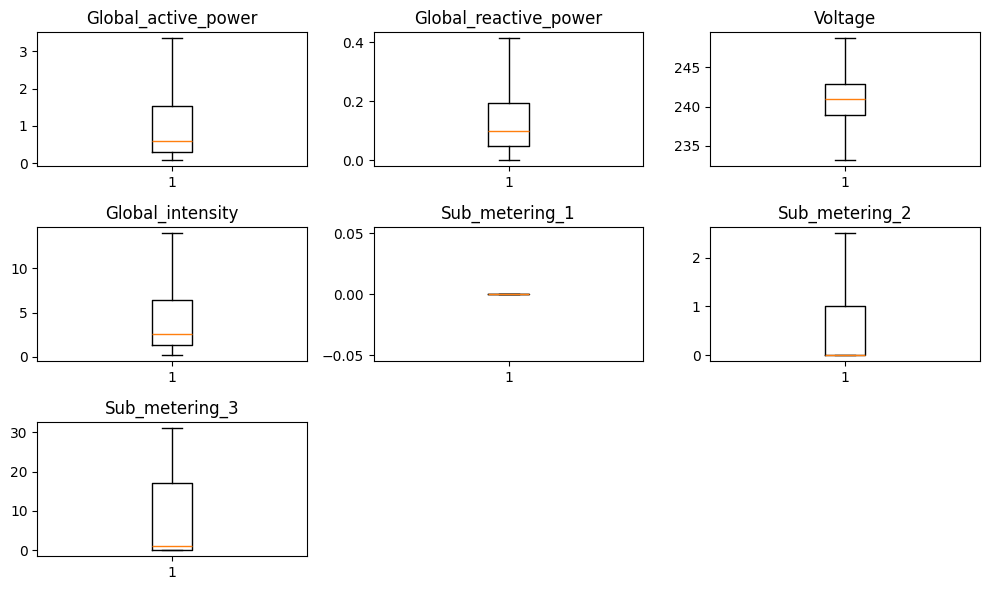

In [ ]:
def boxplotting(stock_data_numeric):
    plt.figure(figsize=(10,6))
    for i, col in enumerate(power_data_numeric.columns):
        plt.subplot(3, 3, i+1)
        plt.boxplot(power_data[col])
        plt.title(col)
    plt.tight_layout()
    plt.show()
boxplotting(power_data_numeric)

                       Global_active_power  Global_reactive_power   Voltage  \
Global_active_power               1.000000               0.247017 -0.399762   
Global_reactive_power             0.247017               1.000000 -0.112246   
Voltage                          -0.399762              -0.112246  1.000000   
Global_intensity                  0.998889               0.266120 -0.411363   
Sub_metering_1                    0.484401               0.123111 -0.195976   
Sub_metering_2                    0.434569               0.139231 -0.167405   
Sub_metering_3                    0.638555               0.089617 -0.268172   

                       Global_intensity  Sub_metering_1  Sub_metering_2  \
Global_active_power            0.998889        0.484401        0.434569   
Global_reactive_power          0.266120        0.123111        0.139231   
Voltage                       -0.411363       -0.195976       -0.167405   
Global_intensity               1.000000        0.489298        0.44

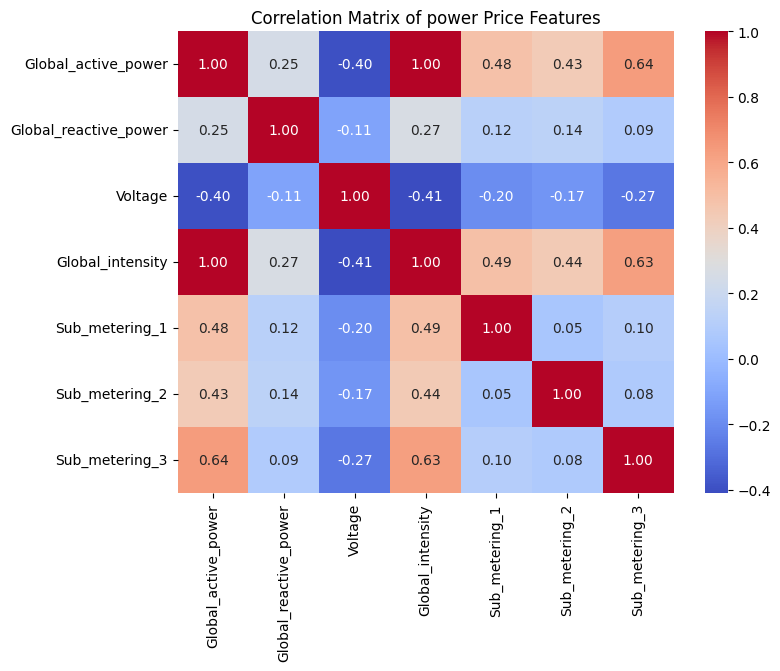

In [ ]:
# Compute Pearson correlation between numerical columns
correlation_matrix = power_data_numeric.corr(method='pearson')

# Display correlation matrix
print(correlation_matrix)

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of power Price Features")
plt.show()

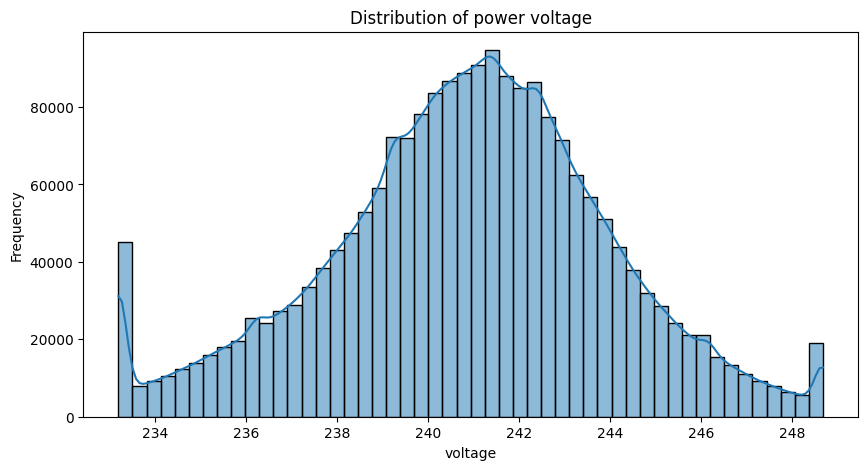

In [ ]:
plt.figure(figsize=(10, 5))
sns.histplot(power_data['Voltage'], bins=50, kde=True)
plt.title("Distribution of power voltage")
plt.xlabel("voltage")
plt.ylabel("Frequency")
plt.show()

Daily power consumption

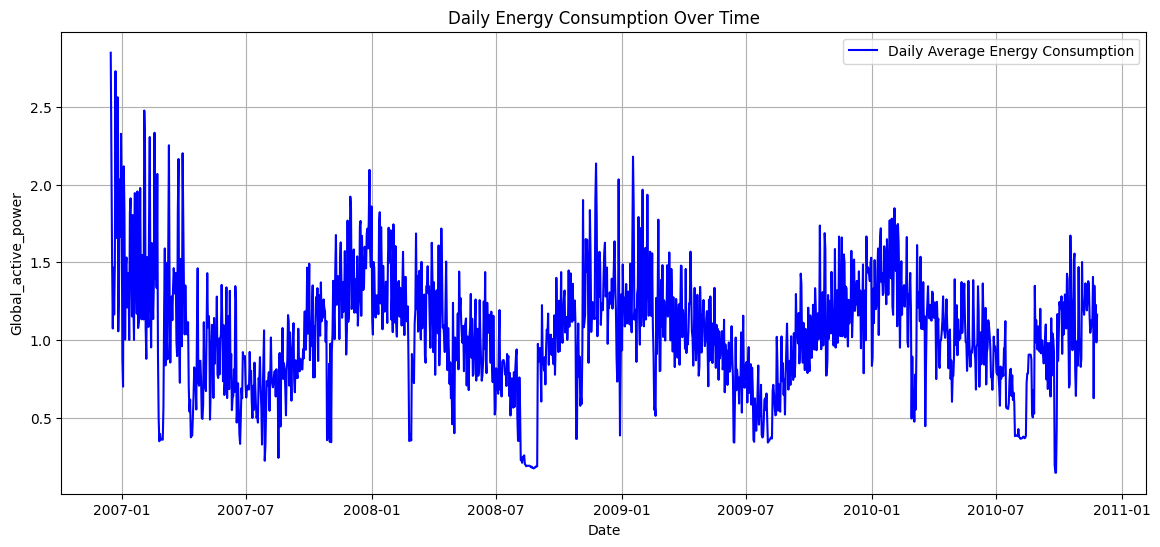

In [ ]:
power_data = power_data.copy()

power_daily_consumption = power_data.resample('D').mean()

plt.figure(figsize=(14, 6))
plt.plot(power_daily_consumption.index, power_daily_consumption['Global_active_power'], label='Daily Average Energy Consumption', color='blue')
plt.xlabel('Date')
plt.ylabel('Global_active_power')
plt.title('Daily Energy Consumption Over Time')
plt.legend()
plt.grid(True)
plt.show()

Hourly consumption

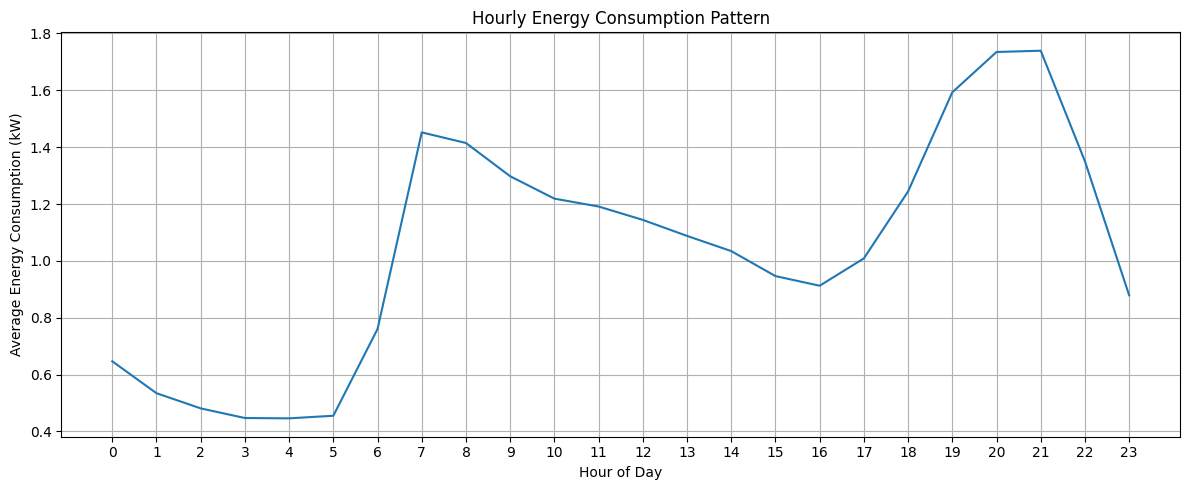

In [ ]:
power_data = power_data.copy()

power_data_hourly = power_data.resample('H').mean()

power_data_hourly['hour'] = power_data_hourly.index.hour

hourly_avg = power_data_hourly.groupby('hour')['Global_active_power'].mean()

plt.figure(figsize=(12, 5))
hourly_avg.plot(linestyle='-')
plt.xlabel("Hour of Day")
plt.ylabel("Average Energy Consumption (kW)")
plt.title("Hourly Energy Consumption Pattern")
plt.grid(True)
plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()


Monthly consumption

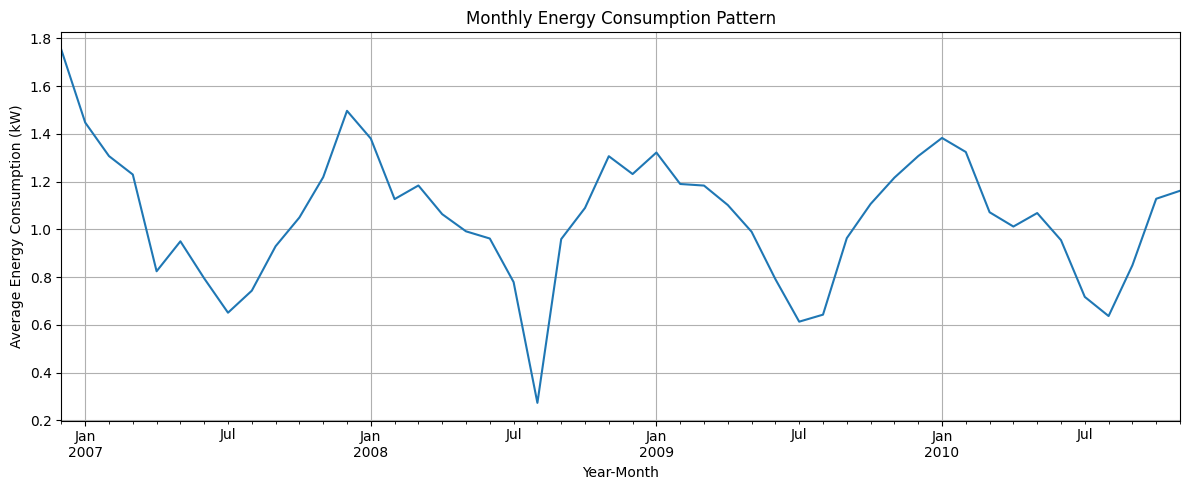

In [ ]:

power_data = power_data.copy()

monthly_avg = power_data['Global_active_power'].resample('M').mean()

plt.figure(figsize=(12, 5))
monthly_avg.plot(linestyle='-')
plt.xlabel("Year-Month")
plt.ylabel("Average Energy Consumption (kW)")
plt.title("Monthly Energy Consumption Pattern")
plt.grid(True)
plt.tight_layout()
plt.show()


Yearly consumption

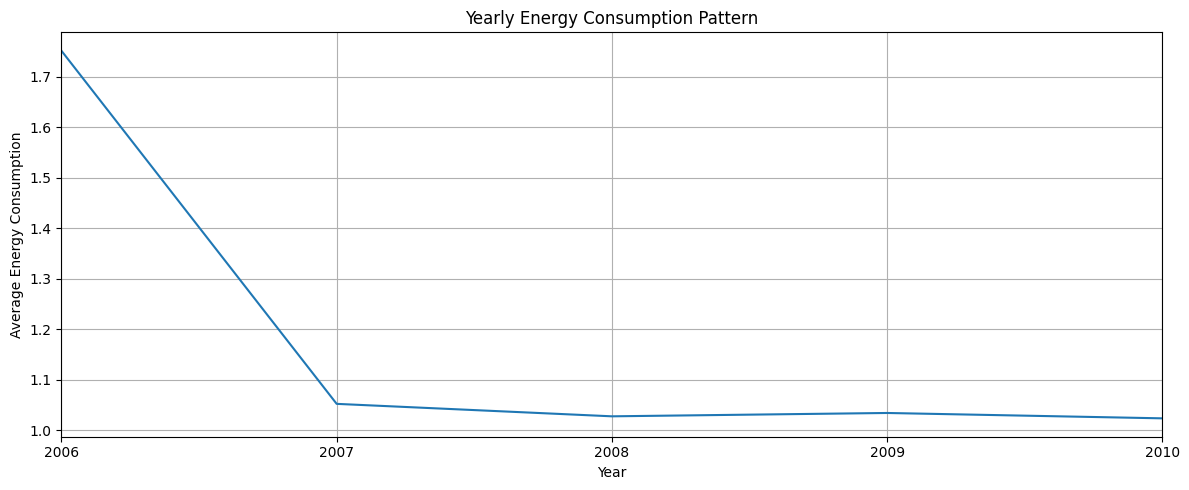

In [ ]:
power_data = power_data.copy()

yearly_avg = power_data['Global_active_power'].resample('YE').mean()

plt.figure(figsize=(12, 5))
yearly_avg.plot(linestyle='-')
plt.xlabel("Year")
plt.ylabel("Average Energy Consumption")
plt.title("Yearly Energy Consumption Pattern")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
power_data.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Datetime,,,,,,,
2006-12-16 17:24:00,3.348,0.413,234.84,13.9,0.0,1.0,17.0
2006-12-16 17:25:00,3.348,0.413,233.63,13.9,0.0,1.0,16.0
2006-12-16 17:26:00,3.348,0.413,233.29,13.9,0.0,2.0,17.0
2006-12-16 17:27:00,3.348,0.413,233.74,13.9,0.0,1.0,17.0
2006-12-16 17:28:00,3.348,0.413,235.68,13.9,0.0,1.0,17.0


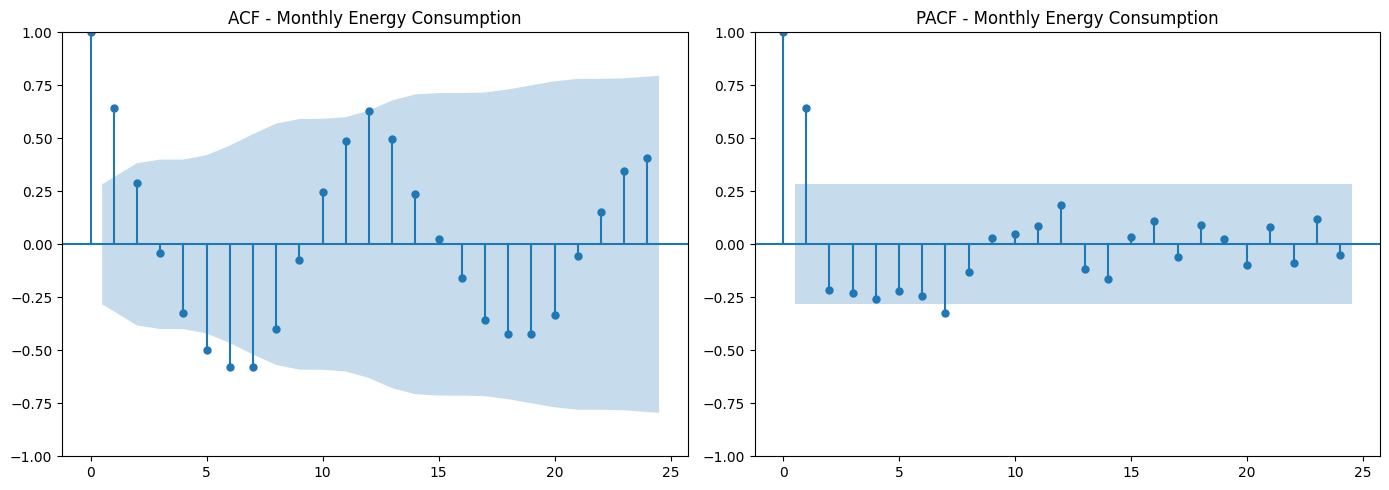

In [ ]:
monthly_data = power_data['Global_active_power'].resample('ME').mean()

monthly_data = monthly_data.dropna()

# Plot ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ACF (Autocorrelation Function)
sm.graphics.tsa.plot_acf(monthly_data, lags=24, ax=axes[0])
axes[0].set_title('ACF - Monthly Energy Consumption')

# PACF (Partial Autocorrelation Function)
sm.graphics.tsa.plot_pacf(monthly_data, lags=24, ax=axes[1])
axes[1].set_title('PACF - Monthly Energy Consumption')

plt.tight_layout()
plt.show()


In [ ]:
adf_result = adfuller(monthly_data)

print("ADF Test Statistic: {:.4f}".format(adf_result[0]))
print("p-value: {:.4f}".format(adf_result[1]))
print("Critical Values:")
for key, value in adf_result[4].items():
    print(f"   {key}: {value:.4f}")

if adf_result[1] < 0.05:
    print("✅ Series is likely stationary (reject H0).")
else:
    print("❌ Series is likely non-stationary (fail to reject H0).")


ADF Test Statistic: -5.3228
p-value: 0.0000
Critical Values:
   1%: -3.6155
   5%: -2.9413
   10%: -2.6092
✅ Series is likely stationary (reject H0).


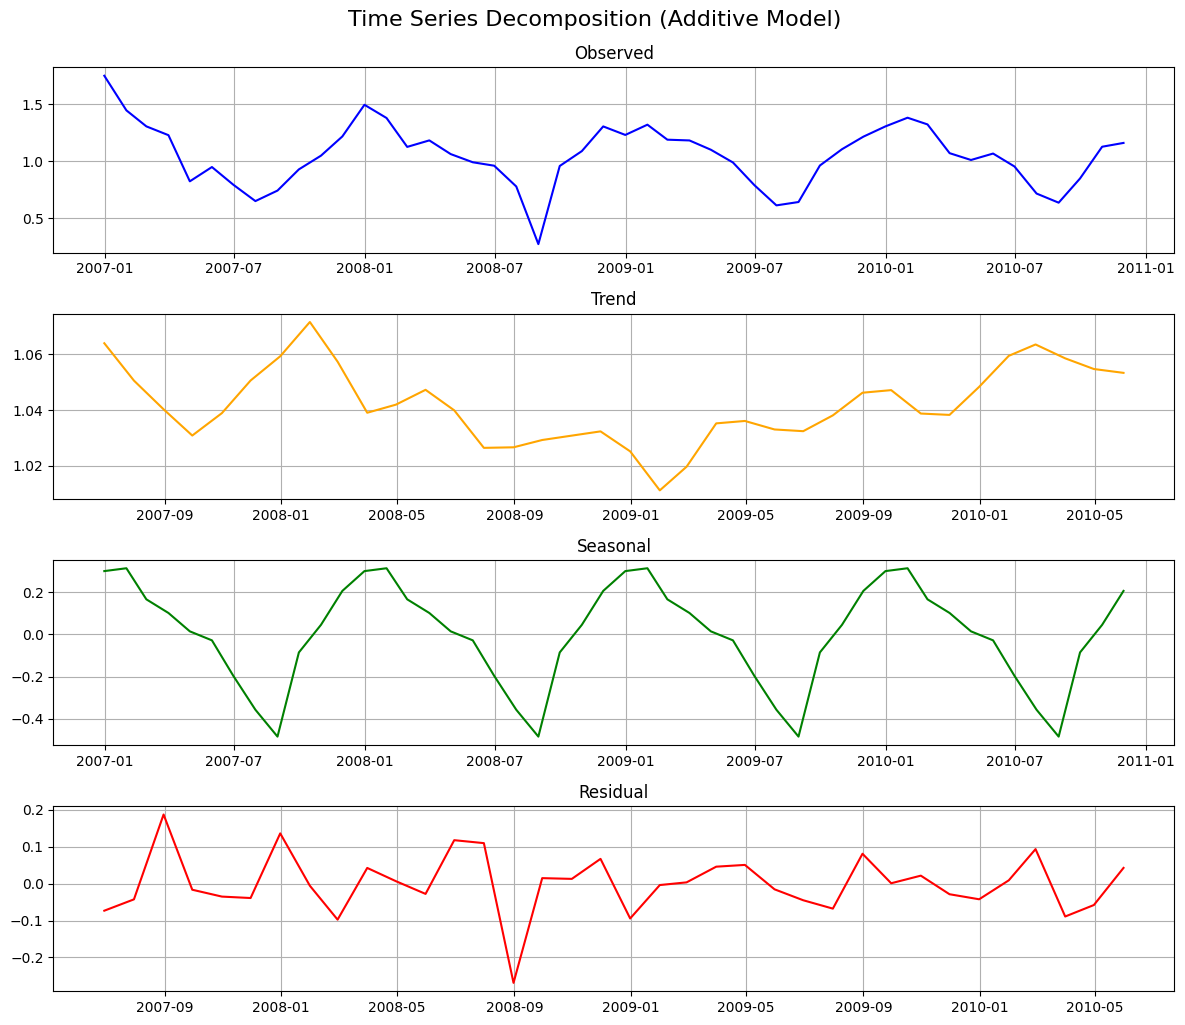

In [ ]:
# Perform decomposition
decomp = seasonal_decompose(monthly_data, model='additive')

# Manually plot each component with different colors
plt.figure(figsize=(12, 10))

plt.subplot(411)
plt.plot(decomp.observed, label='Observed', color='blue')
plt.title('Observed')
plt.grid(True)

plt.subplot(412)
plt.plot(decomp.trend, label='Trend', color='orange')
plt.title('Trend')
plt.grid(True)

plt.subplot(413)
plt.plot(decomp.seasonal, label='Seasonal', color='green')
plt.title('Seasonal')
plt.grid(True)

plt.subplot(414)
plt.plot(decomp.resid, label='Residual', color='red')
plt.title('Residual')
plt.grid(True)

plt.tight_layout()
plt.suptitle("Time Series Decomposition (Additive Model)", fontsize=16, y=1.02)
plt.show()


In [ ]:
power_data.shape

(2075259, 7)

In [205]:
# Create lag features
power_data['lag_1'] = power_data['Global_active_power'].shift(1)
power_data['lag_7'] = power_data['Global_active_power'].shift(7)

# Create rolling mean features
power_data['rolling_mean_7'] = power_data['Global_active_power'].rolling(window=7).mean()
power_data['rolling_mean_30'] = power_data['Global_active_power'].rolling(window=30).mean()

# Droping values generated by shifting/rolling
power_data.dropna(inplace=True)

print(power_data.head())

                     Global_active_power  Global_reactive_power  Voltage  \
Datetime                                                                   
2006-12-16 17:53:00                3.178                  0.000   235.28   
2006-12-16 17:54:00                2.720                  0.000   235.06   
2006-12-16 17:55:00                3.348                  0.076   234.17   
2006-12-16 17:56:00                3.348                  0.090   233.77   
2006-12-16 17:57:00                3.348                  0.000   233.62   

                     Global_intensity  Sub_metering_1  Sub_metering_2  \
Datetime                                                                
2006-12-16 17:53:00              13.4             0.0             0.0   
2006-12-16 17:54:00              11.6             0.0             0.0   
2006-12-16 17:55:00              13.9             0.0             0.0   
2006-12-16 17:56:00              13.9             0.0             0.0   
2006-12-16 17:57:00          

In [206]:
power_data = power_data.sort_index()

# Defining the split index
train_size = int(len(power_data) * 0.8)

# Splitting the data
train_power_data= power_data.iloc[:train_size]
test_power_data = power_data.iloc[train_size:]

# Display the sizes
print(f"Training Data: {train_power_data.shape}")
print(f"Testing Data: {test_power_data.shape}")

Training Data: (1660184, 11)
Testing Data: (415046, 11)


In [207]:
# Daily resample
train_daily = train_power_data['Global_active_power'].resample('D').mean()
test_daily = test_power_data['Global_active_power'].resample('D').mean()

# Display the sizes
print(f"Training daily Data: {train_daily.shape}")
print(f"Testing daily Data: {test_daily.shape}")


Training daily Data: (1154,)
Testing daily Data: (289,)


## Statistical Forecasting

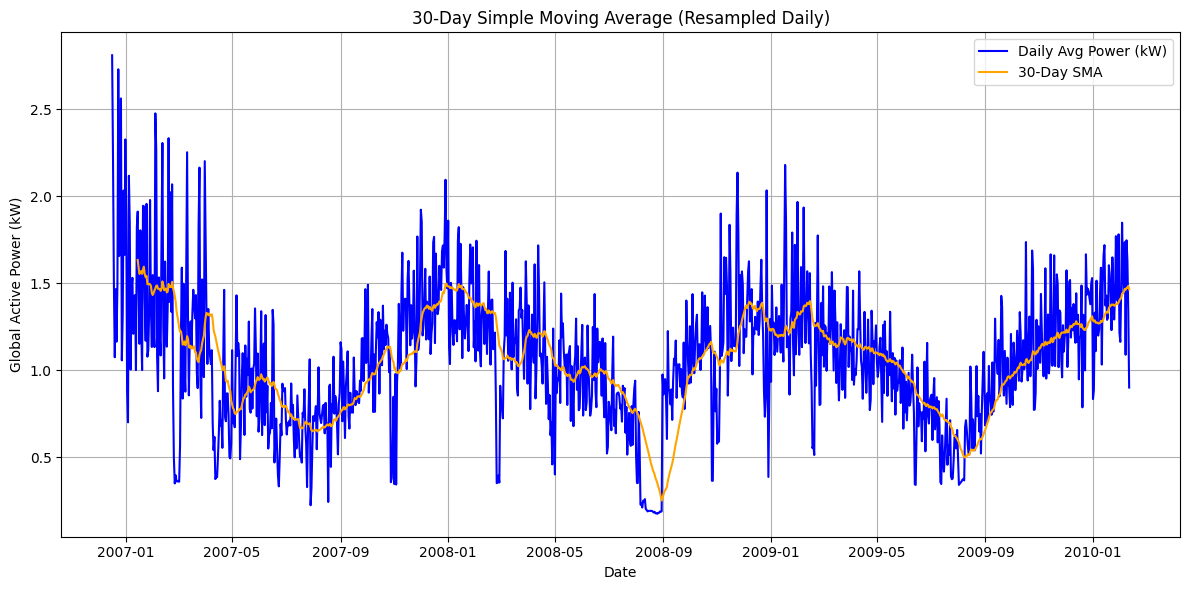

In [ ]:

# Recalculate the moving average
power_daily_sma = train_daily.rolling(window=30).mean()

# Plot clean version
plt.figure(figsize=(12, 6))
plt.plot(train_daily, label='Daily Avg Power (kW)', color='blue')
plt.plot(power_daily_sma, label='30-Day SMA', color='orange')
plt.title('30-Day Simple Moving Average (Resampled Daily)')
plt.xlabel('Date')
plt.ylabel('Global Active Power (kW)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


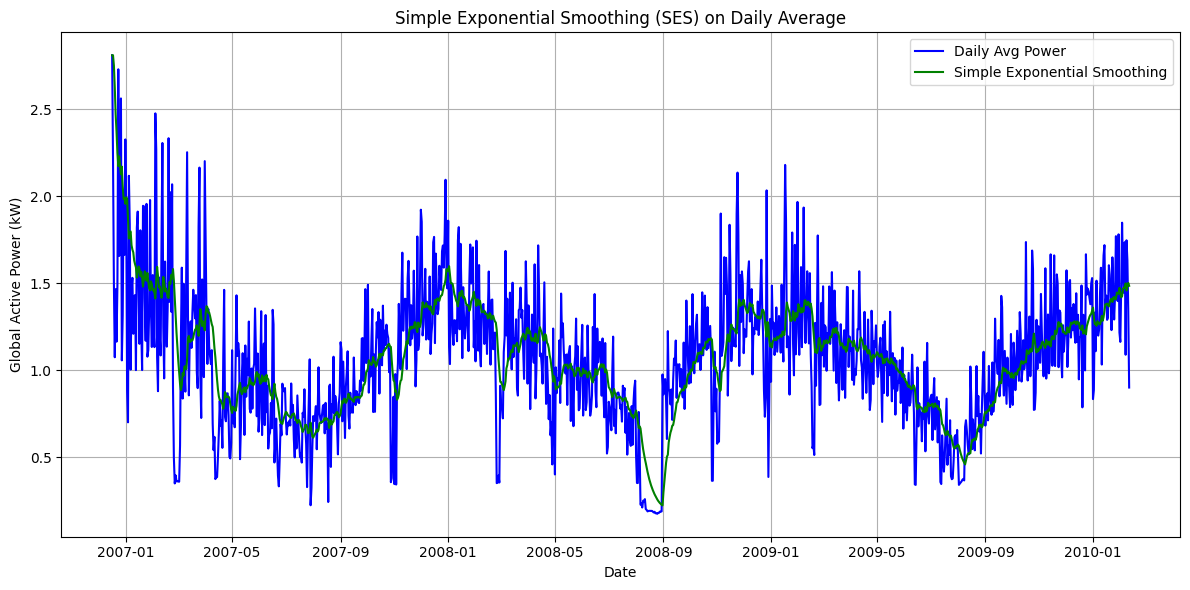

In [ ]:

ses_model = SimpleExpSmoothing(train_daily).fit(smoothing_level=0.1, optimized=False)

# Get smoothed values
power_daily_ses = ses_model.fittedvalues

# Plot
plt.figure(figsize=(12, 6))
plt.plot(train_daily, label='Daily Avg Power', color='blue')
plt.plot(power_daily_ses, label='Simple Exponential Smoothing', color='green')
plt.title('Simple Exponential Smoothing (SES) on Daily Average')
plt.xlabel('Date')
plt.ylabel('Global Active Power (kW)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:


warnings.filterwarnings("ignore")

# Drop NAs and subset
ts_data = power_data['Global_active_power'].dropna().iloc[-5000:]

# Grid search
p = q = range(0, 4)
d = [0]
pdq = list(itertools.product(p, d, q))

best_aic = float("inf")
best_order = None
best_model = None

print("Starting ARIMA Grid Search...")

for order in pdq:
    try:
        model = sm.tsa.ARIMA(ts_data, order=order)
        results = model.fit()
        if results.aic < best_aic:
            best_aic = results.aic
            best_order = order
            best_model = results
        print(f"ARIMA{order} AIC: {results.aic:.2f}")
    except Exception as e:
        print(f"ARIMA{order} failed: {e}")
        continue

print("\nBest ARIMA order:", best_order)
print("Best AIC:", best_aic)


Starting ARIMA Grid Search...
ARIMA(0, 0, 0) AIC: 12177.01
ARIMA(0, 0, 1) AIC: 6657.17
ARIMA(0, 0, 2) AIC: 3510.95
ARIMA(0, 0, 3) AIC: 1687.79
ARIMA(1, 0, 0) AIC: -2408.20
ARIMA(1, 0, 1) AIC: -2419.51
ARIMA(1, 0, 2) AIC: -2457.87
ARIMA(1, 0, 3) AIC: -2455.96
ARIMA(2, 0, 0) AIC: -2416.99
ARIMA(2, 0, 1) AIC: -2439.56
ARIMA(2, 0, 2) AIC: -2455.93
ARIMA(2, 0, 3) AIC: -2454.20
ARIMA(3, 0, 0) AIC: -2458.19
ARIMA(3, 0, 1) AIC: -2456.92
ARIMA(3, 0, 2) AIC: -2455.19
ARIMA(3, 0, 3) AIC: -2454.20

Best ARIMA order: (3, 0, 0)
Best AIC: -2458.185927446634


In [ ]:

train_power_data = train_power_data.groupby('Datetime').agg({'Global_active_power': 'mean'}).reset_index()

train_power_data.set_index('Datetime', inplace=True)
train_power_data = train_power_data.asfreq('B')

train_power_data['Global_active_power'] = train_power_data['Global_active_power'].ffill().bfill()

model = sm.tsa.ARIMA(train_power_data['Global_active_power'], order=(3, 0, 0))
results = model.fit()

print(results.summary())


                                SARIMAX Results                                
Dep. Variable:     Global_active_power   No. Observations:                  823
Model:                  ARIMA(3, 0, 0)   Log Likelihood               -1004.639
Date:                 Mon, 14 Apr 2025   AIC                           2019.277
Time:                         06:17:50   BIC                           2042.842
Sample:                     12-18-2006   HQIC                          2028.317
                          - 02-10-2010                                         
Covariance Type:                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9695      0.086     11.227      0.000       0.800       1.139
ar.L1          0.1474      0.035      4.254      0.000       0.079       0.215
ar.L2          0.1730      0.034      5.067 

In [ ]:
steps=30
forecast_values = results.forecast(steps=steps)

actual_values = train_daily.iloc[-30:].values

#forecast values
forecast_values.head()

# RMSE (Root Mean Squared Error)
rmse = np.sqrt(mean_squared_error(actual_values, forecast_values))
print(f"RMSE: {rmse}")

# MAE (Mean Absolute Error)
mae = mean_absolute_error(actual_values, forecast_values)
print(f"MAE: {mae}")

# MAPE (Mean Absolute Percentage Error)
mape = np.mean(np.abs((actual_values - forecast_values) / actual_values)) * 100
print(f"MAPE: {mape}%")

RMSE: 0.49103911452823457
MAE: 0.43145723191045643
MAPE: 28.053028112066254%


In [ ]:
forecast_values.head()

,predicted_mean
2010-02-11 17:53:00,1.497189
2010-02-12 17:53:00,1.316282
2010-02-15 17:53:00,1.362621
2010-02-16 17:53:00,1.174447
2010-02-17 17:53:00,1.124891


In [ ]:
forecast_values.tail()

,predicted_mean
2010-03-18 17:53:00,0.969643
2010-03-19 17:53:00,0.969605
2010-03-22 17:53:00,0.969577
2010-03-23 17:53:00,0.969557
2010-03-24 17:53:00,0.969543


In [ ]:


# Fit ARIMA (or use auto_arima from pmdarima)
model = sm.tsa.ARIMA(train_daily, order=(3,0,0)).fit()

# Forecast 30 steps ahead
forecast_steps = 30
forecast = model.forecast(steps=forecast_steps)

# Generate future dates
last_date = train_daily.index[-1]
forecast_index = pd.date_range(start=last_date + timedelta(days=1), periods=forecast_steps, freq='D')
forecast_series = pd.Series(forecast, index=forecast_index)


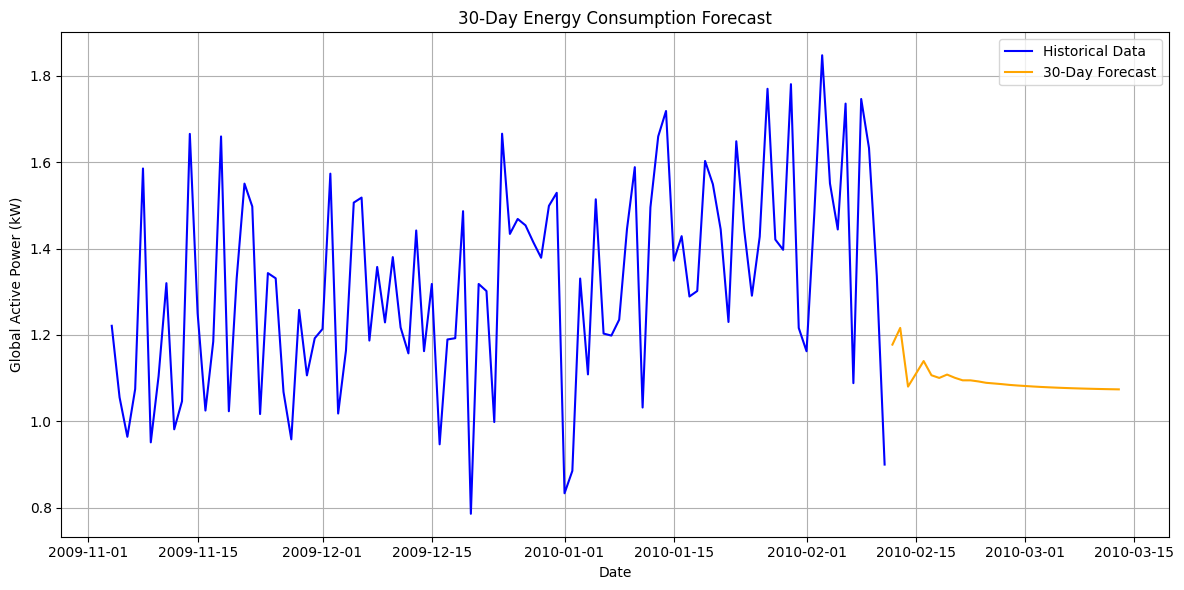

In [ ]:


plt.figure(figsize=(12, 6))
plt.plot(train_daily[-100:], label='Historical Data', color='blue')  # last 100 days for clarity
plt.plot(forecast_series, label='30-Day Forecast', color='orange')

plt.title('30-Day Energy Consumption Forecast')
plt.xlabel('Date')
plt.ylabel('Global Active Power (kW)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Machine Learning Forecasting

In [208]:
power_data['month'] = power_data.index.month
power_data["day_of_week"] = power_data.index.dayofweek

# Get US Federal Holidays
cal = USFederalHolidayCalendar()
holidays = cal.holidays(start=power_data.index.min(), end=power_data.index.max())

# Mark if the date is a holiday
power_data["is_holiday"] = power_data.index.isin(holidays).astype(int)
power_data.head()


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,lag_1,lag_7,rolling_mean_7,rolling_mean_30,month,day_of_week,is_holiday
Datetime,,,,,,,,,,,,,,
2006-12-16 17:53:00,3.178,0.000,235.28,13.4,0.0,0.0,17.0,3.258,3.348,3.263429,3.322933,12,5,0
2006-12-16 17:54:00,2.720,0.000,235.06,11.6,0.0,0.0,17.0,3.178,3.348,3.173714,3.302000,12,5,0
2006-12-16 17:55:00,3.348,0.076,234.17,13.9,0.0,0.0,17.0,2.720,3.348,3.173714,3.302000,12,5,0
2006-12-16 17:56:00,3.348,0.090,233.77,13.9,0.0,0.0,16.0,3.348,3.248,3.188000,3.302000,12,5,0
2006-12-16 17:57:00,3.348,0.000,233.62,13.9,0.0,0.0,17.0,3.348,3.236,3.204000,3.302000,12,5,0


In [209]:
def create_lagged_features(power_data, target_col="Global_active_power", lags=8):
    for i in range(1, lags+1):
        power_data[f"lag_{i}"] = power_data[target_col].shift(i)
    return power_data

power_data = create_lagged_features(power_data, target_col="Global_active_power", lags=10)
power_data.dropna(inplace=True)
print(power_data.head())


                     Global_active_power  Global_reactive_power  Voltage  \
Datetime                                                                   
2006-12-16 18:03:00                3.348                  0.108  236.930   
2006-12-16 18:04:00                3.348                  0.202  235.010   
2006-12-16 18:05:00                3.348                  0.192  233.195   
2006-12-16 18:06:00                3.348                  0.186  233.195   
2006-12-16 18:07:00                3.348                  0.144  233.195   

                     Global_intensity  Sub_metering_1  Sub_metering_2  \
Datetime                                                                
2006-12-16 18:03:00              13.9             0.0             2.5   
2006-12-16 18:04:00              13.9             0.0             2.5   
2006-12-16 18:05:00              13.9             0.0             2.5   
2006-12-16 18:06:00              13.9             0.0             2.5   
2006-12-16 18:07:00          

In [210]:

power_data["rolling_std_7"] = power_data["Global_active_power"].rolling(window=7).std()
power_data.dropna(inplace=True)
print(power_data.head())


                     Global_active_power  Global_reactive_power  Voltage  \
Datetime                                                                   
2006-12-16 18:09:00                3.348                  0.136   234.66   
2006-12-16 18:10:00                3.348                  0.148   236.20   
2006-12-16 18:11:00                3.090                  0.152   237.07   
2006-12-16 18:12:00                3.348                  0.144   235.78   
2006-12-16 18:13:00                2.308                  0.160   237.43   

                     Global_intensity  Sub_metering_1  Sub_metering_2  \
Datetime                                                                
2006-12-16 18:09:00              13.9             0.0             2.5   
2006-12-16 18:10:00              13.9             0.0             2.5   
2006-12-16 18:11:00              13.8             0.0             2.5   
2006-12-16 18:12:00              13.9             0.0             2.5   
2006-12-16 18:13:00          

In [ ]:


# Define features (X) and target (y)
X = power_data.drop(columns=["Global_active_power"])
y = power_data["Global_active_power"]

# Splitting dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling data (important for Linear Regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Linear regression

In [ ]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

y_pred_lr = lr_model.predict(X_test)

print("Linear Regression RMSE:", mean_squared_error(y_test, y_pred_lr)**0.5)
print("R² Score:", r2_score(y_test, y_pred_lr))
print('MSE:',mean_squared_error(y_test, y_pred_lr))
print('MAE:', mean_absolute_error(y_test, y_pred_lr))


Linear Regression RMSE: 6.907308411389656e-15
R² Score: 1.0
MSE: 4.7710909490054297e-29
MAE: 5.774008659738983e-15


### Random forest

In [ ]:
daily_data = power_data['Global_active_power'].resample('D').mean().to_frame()

# Create lag features
daily_data['lag_1'] = daily_data['Global_active_power'].shift(1)
daily_data['lag_7'] = daily_data['Global_active_power'].shift(7)

# Create rolling mean features (Adjust window if needed)
daily_data['rolling_mean_7'] = daily_data['Global_active_power'].rolling(window=7).mean()
daily_data['rolling_mean_30'] = daily_data['Global_active_power'].rolling(window=30).mean()

# Create day of week, is_holiday, and month features
daily_data['Day_of_week'] = daily_data.index.dayofweek
daily_data['is_holiday'] = daily_data.index.isin(holidays).astype(int)
daily_data['month'] = daily_data.index.month

# Dropping NaN values introduced by lags and rolling calculations
daily_data.dropna(inplace=True)

features = ['lag_1', 'lag_7', 'Day_of_week', 'is_holiday', 'month', 'rolling_mean_7', 'rolling_mean_30']
target = 'Global_active_power'

X = daily_data[features]
y = daily_data[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [ ]:
# Train model
rf = RandomForestRegressor(n_estimators=50, n_jobs=-1, random_state=42)
rf.fit(X_train, y_train)

# Predict
y_pred = rf.predict(X_test)

# Evaluate
# Evaluate
print("Random Forest RMSE:", mean_squared_error(y_test, y_pred)**0.5)  # Calculate RMSE manually
print("R² Score:", r2_score(y_test, y_pred))
print('MSE:',mean_squared_error(y_test, y_pred))
print('MAE:', mean_absolute_error(y_test, y_pred))

Random Forest RMSE: 0.20930780091686982
R² Score: 0.4871345052121794
MSE: 0.04380975552465601
MAE: 0.155231262916085


### hyperparameter tuning

linear regression

In [ ]:
# Define parameter grid
ridge_params = {"alpha": [0.01, 0.1, 1, 10, 100]}

# Perform Grid Search
ridge_grid = GridSearchCV(Ridge(), ridge_params, cv=3, scoring="neg_mean_squared_error")
ridge_grid.fit(X_train_scaled, y_train)

# Get best model
best_ridge = ridge_grid.best_estimator_

# Evaluate model
ridge_predictions = best_ridge.predict(X_test_scaled)
ridge_rmse = np.sqrt(mean_squared_error(y_test, ridge_predictions))
ridge_r2 = r2_score(y_test, ridge_predictions)


print(f"Best Ridge Regression tuned -> Alpha: {ridge_grid.best_params_['alpha']}, RMSE: {ridge_rmse}, R²: {ridge_r2}")
print('MSE:',mean_squared_error(y_test, ridge_predictions))
print('MAE:', mean_absolute_error(y_test, ridge_predictions))


Best Ridge Regression tuned -> Alpha: 0.01, RMSE: 6.951773792380918e-06, R²: 0.9999999999417577
MSE: 4.8327158860434175e-11
MAE: 4.3806015529061285e-06


random forest

In [ ]:
from random import randint
from sklearn.model_selection import RandomizedSearchCV


In [ ]:
# Define parameter distributions
param_dist = {
    'n_estimators': [int(x) for x in np.linspace(start = 20, stop = 40, num = 10)],
    'max_depth': [10],
    'min_samples_split': [2,],
    'min_samples_leaf': [1, 2],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Initialize model
rf = RandomForestRegressor(random_state=42, n_jobs=-1)

# Setup randomized search
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=5,  # Number of different combinations to try
    cv=3,  # 3-fold cross-validation
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=2,
    random_state=42
)

# Run search
random_search.fit(X_train, y_train)

# Print results
print("Best Parameters:", random_search.best_params_)

# Evaluate on test set
# Evaluate on test set
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)

# Calculate RMSE without the 'squared' parameter
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Tuned RF RMSE:", rmse)
print("Tuned RF R² Score:", r2_score(y_test, y_pred))
print('MSE:',mean_squared_error(y_test,y_pred ))
print('MAE:', mean_absolute_error(y_test, y_pred))



Fitting 3 folds for each of 5 candidates, totalling 15 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
9 fits failed out of a total of 15.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
6 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_pa

Best Parameters: {'n_estimators': 33, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 10}
Tuned RF RMSE: 0.06321469507504973
Tuned RF R² Score: 0.9951840360239426
MSE: 0.003996097673431517
MAE: 0.03183396348199251


## Deep Learning for Time Series

In [211]:
# Prepare data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(power_data[['Global_active_power']])

# Create sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 3
X, y = create_sequences(scaled_data, seq_length)

# Adjust the timestamps to align with y
target_dates = power_data.index[seq_length:]

# Calculate train_size before using it
train_size = int(len(X) * 0.8)

date_train = target_dates[:train_size]
date_test = target_dates[train_size:]

# Train/Test split
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [212]:
# Function to create sequences for LSTM input
def create_lstm_dataset(data, look_back=30):
    X, y = [], []
    for i in range(look_back, len(data)):
        X.append(data[i-look_back:i, 0])  # Sequence of previous 'look_back' steps
        y.append(data[i, 0])              # The target is the next time step value
    return np.array(X), np.array(y)

# Create dataset
X, y = create_lstm_dataset(scaled_data, look_back=30)

# Split data into training and test sets (80-20 split)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(power_data['Global_active_power'].values.reshape(-1, 1))



In [213]:

# Reshape data for LSTM (3D input)
X_train_reshaped = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test_reshaped = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Define LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=False, input_shape=(X_train_reshaped.shape[1], 1)))
model.add(Dense(units=1))  # Output layer

model.compile(optimizer='adam', loss='mean_squared_error')



/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [214]:
# Train the model
model.fit(X_train_reshaped, y_train, epochs=3, batch_size=300)

# ✅ Save the model properly
model.save("lstm_model.keras")

# Make predictions
lstm_predictions = model.predict(X_test_reshaped)

# Ensure y_test is reshaped properly for inverse_transform
y_test_reshaped = y_test.reshape(-1, 1)

# Inverse scale both y_test and predictions
y_test_inverse = scaler.inverse_transform(y_test_reshaped)
lstm_predictions_inverse = scaler.inverse_transform(lstm_predictions)




Epoch 1/3
5534/5534 ━━━━━━━━━━━━━━━━━━━━ 302s 54ms/step - loss: 0.0067
Epoch 2/3
5534/5534 ━━━━━━━━━━━━━━━━━━━━ 331s 55ms/step - loss: 0.0041
Epoch 3/3
5534/5534 ━━━━━━━━━━━━━━━━━━━━ 309s 56ms/step - loss: 0.0040
12970/12970 ━━━━━━━━━━━━━━━━━━━━ 59s 5ms/step


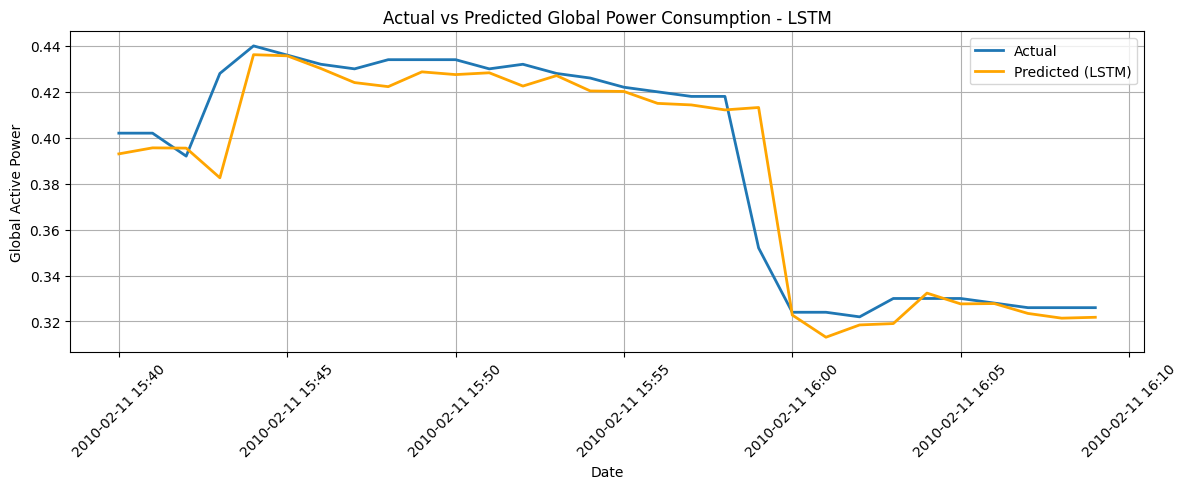

In [215]:

import matplotlib.dates as mdates


# Ensure datetime
date_test = pd.to_datetime(date_test)

# Number of points to plot
num_points_to_plot = 30

# Create plot
plt.figure(figsize=(12, 5))
ax = plt.gca()

# ⏰ Show both date and time
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))

# Optional: Auto-rotate date labels
plt.xticks(rotation=45)

# Plot actual vs predicted
plt.plot(
    date_test[:num_points_to_plot],
    y_test_inverse[:num_points_to_plot],
    label='Actual', linewidth=2
)
plt.plot(
    date_test[:num_points_to_plot],
    lstm_predictions_inverse[:num_points_to_plot],
    label='Predicted (LSTM)', linewidth=2, color='orange'
)

plt.legend()
plt.title('Actual vs Predicted Global Power Consumption - LSTM')
plt.ylabel('Global Active Power')
plt.xlabel('Date')
plt.grid(True)
plt.tight_layout()
plt.show()


## Compare LSTM results with ML & ARIMA models.

In [ ]:
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test_inverse, lstm_predictions_inverse))
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

# Calculate MAE
mae = mean_absolute_error(y_test_inverse, lstm_predictions_inverse)
print(f"Mean Absolute Error (MAE): {mae:.4f}")

# Calculate R² Score
r2 = r2_score(y_test_inverse, lstm_predictions_inverse)
print(f"R² Score: {r2:.4f}")


Root Mean Squared Error (RMSE): 0.1778
Mean Absolute Error (MAE): 0.0774
R² Score: 0.9507


## Best model deploy

In [216]:
!pkill streamlit
from pyngrok import ngrok
ngrok.kill()

In [233]:
# Save the model
model.save("lstm_model.keras")

In [234]:
import os
print(os.path.getsize("lstm_model.keras"))  # Should be > 0


149134


In [235]:
import joblib
# Save the scaler
joblib.dump(scaler, "lstm_scaler.pkl")


['lstm_scaler.pkl']

In [236]:
%%writefile streamlit_app2.py
import streamlit as st
import numpy as np
import pandas as pd
import joblib
from tensorflow.keras.models import load_model  # ✅ ADD THIS LINE

# Load model and scaler
model = load_model("lstm_model.keras")
scaler = joblib.load("lstm_scaler.pkl")

st.set_page_config(page_title="Power Forecast (LSTM)", layout="centered")
st.title("⚡ Power Consumption Forecast with LSTM")
st.markdown("Input the latest 30 time steps to predict the next power value.")

# Get 30-step input from user
input_steps = []
for i in range(30):
    val = st.number_input(f"Step {i+1}", value=0.0, format="%.4f")
    input_steps.append(val)

if st.button("🔮 Predict Next Value"):
    # Prepare input
    input_array = np.array(input_steps).reshape(1, 30, 1)

    # Predict
    prediction = model.predict(input_array)

    # Inverse transform
    predicted_value = scaler.inverse_transform(prediction)[0][0]

    st.success(f"Predicted Global Active Power: **{predicted_value:.3f} kW**")


Overwriting streamlit_app2.py


In [237]:
from pyngrok import ngrok

# Paste your token in the string below:
NGROK_AUTH_TOKEN = "2vo5Fxumho4plWFGt9qjNGvo8Se_7LV4KjLYG1Z7x3Fb55WC3"
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

In [238]:
# Start Streamlit in the background
!streamlit run streamlit_app2.py &>/content/logs.txt &

# Wait for the app to boot (optional: delay for safety)
import time
time.sleep(5)

# Open the ngrok tunnel
public_url = ngrok.connect(8501)
print(f"🌐 Streamlit app is live at: {public_url}")

🌐 Streamlit app is live at: NgrokTunnel: "https://1ee8-34-122-53-96.ngrok-free.app" -> "http://localhost:8501"


In [243]:
from pyngrok import ngrok

tunnels = ngrok.get_tunnels()
for tunnel in tunnels:
    print(tunnel.public_url)

https://1ee8-34-122-53-96.ngrok-free.app


In [242]:
# Disconnect existing tunnels (replace with actual tunnel URLs if known)
ngrok.disconnect("https://73d0-34-122-53-96.ngrok-free.app")

# Critical Thinking Questions
---

## Why stationarity is important in time times forecasting
---

With Stationarity, the time series data is assumed to constant for variance, covariance and mean and here’s why it’s important:

 **Predictability of Future Values**:
   - **Stationary** time series data have properties (such as mean, variance, and autocovariance) that do not change over time. This makes the series more predictable, as patterns in the data remain consistent over time.

 **Assumption of Statistical Models**:
   - Many time series models, such as **Autoregressive Integrated Moving Average (ARIMA)**, **Exponential Smoothing**, and **GARCH** models, assume that the time series is stationary. These models rely on the assumption that the data’s statistical properties do not change over time.

**Stationary Time Series are Easier to Model**:
   - When a series is stationary, the model’s behavior remains consistent over time, which simplifies the process of fitting the model.

 **Statistical Inference**:
   - Statistical tests and hypothesis tests for time series often require stationarity because these tests depend on the assumption that the data are consistent over time.


  When applying **ARIMA** (AutoRegressive Integrated Moving Average) models to time series data, non-stationary data can lead to several issues. ARIMA models are designed to work with stationary data, and when the data is non-stationary, it may not behave as expected, leading to inaccurate results. Here's a breakdown of how non-stationary data impacts ARIMA models:

   - **ARIMA models** assume that the data is stationary, which means that the statistical properties (mean, variance, autocovariance) of the time series do not change over time.
   - If the data is non-stationary, the model’s underlying assumptions are violated, leading to unreliable parameter estimates and poor forecasting performance. components(paramters) of the ARIMA model assume that the relationships between past and current values of the time series are stable over time. Non-stationary data (e.g., data with trends or changing variances) disturbs these relationships, making the estimated parameters of the AR and MA terms inaccurate. (the “I” in ARIMA) is used to remove non-stationarity, such as trends. However, if this step is not performed properly, the ARIMA model may not capture the true underlying structure of the data, leading to poor forecasting performance.

   -  If the time series has a trend (e.g., increasing or decreasing over time), this violates the assumption of stationarity, causing the ARIMA model to overfit to the trend and fail to model the actual fluctuations properly.
     - The ARIMA model would try to fit a trend component that doesn't exist in the underlying data (e.g., overfitting to the long-term growth or decline), leading to poor out-of-sample forecasting.
   - If the data has seasonality (i.e., repeating patterns at fixed intervals), ARIMA models might fail to capture this seasonal component if it's not made stationary.


## Based on your visualizations, does seasonality appear to be a major factor in either dataset? Justify your answer with observations from your analysis
---

For stock price, seasonality appears to be a factor since at the beginning of every year there's a rise in the stock price

For electricity consumption, the data shows stationarity thus making seasonality not a major factor

##  Compare and contrast ARIMA and Exponential Smoothing. When would you prefer one over the other? Provide a real-world example
---

|  feature                 |        ARIMA                   |Exponential smoothing         |
|--------------------------|--------------------------------|----------------------|
|  Model Structure         |Combines autoregression, differencing, and moving averages.|Uses weighted averages of past values
|  Stationarity Requirement| Requires the data to be stationary or made stationary through differencing.|Can handle both stationary and non-stationary series, especially with trend and seasonality.                                
|  Trend & Seasonality     |Can model both trend and seasonality if SARIMA is used.|Can model trend and seasonality using Holt-Winters.
|  Complexity              |More complex due to model parameters (AR, I, MA) and requires careful identification of p, d, q.|Simpler to implement, requires fewer parameters and hyperparameters to tune.
|  Model Fit               |Requires the estimation of more parameters and model diagnostics.|Easier to fit, particularly with fewer parameters and no diagnostic checking required.
|  Forecast Horizon        |Effective for medium to long-term forecasts, especially when data has complex patterns.|Generally better for short-term forecasts, especially if the data is highly volatile.



### When to Prefer ARIMA ###
Stationary data with trend: When the data is stationary or can be made stationary by differencing, and there’s a clear trend over time.

Complex relationships: When the time series has significant autocorrelation and the relationships between past values and future values are complex.

No clear seasonality: ARIMA can handle trends well, but if there is no obvious seasonal pattern, it might be preferred over Exponential Smoothing.

Longer-term forecasting: ARIMA is effective for making medium- to long-term forecasts, especially when there are complex underlying relationships.


### When to Prefer Exponential Smoothing ###
Data with trend and/or seasonality: If your data exhibits a clear trend or seasonality, especially when seasonality repeats annually or on a fixed schedule.

Short-term forecasting: Exponential smoothing models, particularly the Holt-Winters method, are often used for short-term forecasting, as they give more weight to the recent observations, making them responsive to recent changes.

Simplicity and computational efficiency: When you need a simple model without the need for extensive parameter tuning and diagnostics. It's also computationally less expensive compared to ARIMA.

### Real-World Example ###
Example : ARIMA in Financial Data
Scenario: You are forecasting the price of a stock over the next few months. The stock exhibits clear long-term trends (e.g., increasing value due to business growth or market conditions), but no seasonality.



## Look at your ARIMA predictions—how well do they match observed trends? If there is a large error, what do you think caused it, and how could you improve the model?
---

### What Causes Large Errors ###
If ARIMA produces large forecasting errors, potential causes include:

- Incorrect Differencing (d):Under-differencing: The data still has a trend, causing ARIMA to miss long-term movements.

- Over-differencing: Too many differences can remove valuable information, making predictions noisy.

- Wrong (p, q) Values:If p and q are not correctly tuned, the model may not capture autocorrelations effectively.AIC/BIC should be used to select the best parameters.

- High Volatility or Non-Stationary Residuals:If residuals are autocorrelated or heteroskedastic (changing variance over time), ARIMA may not fit well.

- Seasonal Patterns Ignored:If the time series has a seasonal pattern (e.g., monthly or yearly fluctuations), a standard ARIMA model will not perform well. SARIMA (Seasonal ARIMA) should be used instead.


### How to Improve an ARIMA Model ###
##### Check Stationarity ####
- Use Augmented Dickey-Fuller (ADF) test to confirm stationarity.
- Apply differencing (d) if the data is non-stationary.

##### Optimize (p, d, q) Selection #####
- Use grid search with AIC/BIC criteria to find the best parameters.
- Use Auto-ARIMA (pmdarima) to automate selection.

##### Analyze Residuals #####
- If residuals show autocorrelation, adjust p or q.
- Ensure residuals are normally distributed with constant variance.

##### Consider SARIMA for Seasonality #####
- If seasonality is present, use SARIMA (Seasonal ARIMA) instead of ARIMA.

##### Use Exogenous Variables (ARIMAX) or Machine Learning #####
- If external factors influence the data, try ARIMAX (ARIMA with regressors).
- Hybrid models like LSTM + ARIMA can work for complex datasets.

## What advantages does machine learning have over ARIMA in time series forecasting? What are some limitations?
---

### Advantages ###
|Feature       |Machine Learning (ML)|ARIMA  |
|--------------|---------------------|-------|
|Data Assumptions|Works well with non-stationary data, handles trends & seasonality automatically|Requires stationary data, needs differencing for trends|
|Feature Engineering|Can incorporate external variables (weather, economic indicators, etc.)|Uses only past values of the target variable|
|Forecasting Horizon|Performs better for long-term predictions|More reliable for short-term forecasts|
|Adaptability  |Works well with changing patterns (stock prices, demand forecasting)|Struggles with sudden structural breaks|
|Scalability|Handles large datasets efficiently|Works well for smaller datasets|

### limitations ###

|features| Machine learning | ARIMA|
|--------|---|-------|
|Requires Large Datasets|Needs a lot of historical data to perform well|Needs a lot of historical data to perform well|
|More Computationally Intensive|Training complex ML models requires high processing power|Simpler & faster for small datasets|
|Harder to Interpret|Deep learning models are a black box|ARIMA’s coefficients are easy to explain|
|Feature Engineering is Critical|Requires careful selection of variables (lags, rolling means, etc.)|Requires only time-series data|

## Based on your results, which model (ML vs ARIMA) performed better? Why do you think that is?
---

ML models performs better compared to ARIMA.
Base on the evalution of the metrics for the different models, ML shows a very some error in accuracy of performance compared to ARIMA that has a relative high evalution error. Also the fact that ARIMA works best with stationary data while ML is able to handle changes in the data

## What is the key advantage of using LSTMs for time series forecasting? How does it handle long-term dependencies compared to traditional models?
---

🔑 Key Advantage of LSTMs:

- Memory of past information over long time intervals.

- Traditional models like ARIMA, Exponential Smoothing, or even basic RNNs struggle to retain information from earlier time steps when sequences are long. LSTMs are designed to overcome this limitation.

💡 How LSTM Handles Long-Term Dependencies:

LSTMs use a unique cell structure with gates (input, forget, and output gates) that control the flow of information. This allows them to:

- Retain important information for long periods.

- Forget irrelevant data as needed.

- Avoid vanishing/exploding gradient problems that plague standard RNNs.

This architecture allows LSTMs to learn what to remember and what to discard, making them very effective for tasks where early time steps influence future outcomes — like energy demand, stock prices, or crop yields.

compared to Traditional Models (e.g., ARIMA) that has :
- Limited or short lags
- Often assumes linearity
- Manually intensive
- Can struggle with large, complex data



##  Examine your deep learning model’s performance—how does it compare to ML and ARIMA? Did it generalize well, or does it show signs of overfitting?
---


## Imagine your energy demand forecast is used by a power company. What business decisions could be influenced by your predictions?
---

 Energy demand forecasts play a critical role in helping power companies make informed and strategic business decisions. Here are several key business decisions that could be influenced by accurate energy demand predictions:

### 1. **Infrastructure Investment and Planning**
   - **Generation Capacity Expansion**: Based on demand forecasts, power companies can decide whether to invest in new power plants or upgrade existing ones to meet future demand. For example, if demand is expected to increase due to population growth or industrial development, they may decide to build new plants or upgrade grid capacity.
   - **Transmission and Distribution Upgrades**: Energy demand predictions help in determining where the power grid needs to be expanded or improved. Areas with growing demand might require additional substations or high-capacity transmission lines to ensure the energy can reach consumers efficiently.
   - **Renewable Energy Integration**: Forecasts can guide decisions on integrating renewable energy sources (e.g., solar, wind) into the grid. These sources have variable outputs, so understanding demand helps in balancing supply from renewables with traditional energy sources.


### 2. **Pricing Strategy and Revenue Management**
   - **Dynamic Pricing**: Energy demand forecasts can inform dynamic pricing strategies. For instance, if high demand is expected during certain times of the day or seasons, the company can adjust electricity prices to optimize consumption and maximize revenue. Conversely, when demand is low, the company may offer discounts to incentivize consumption.
   - **Load Shifting Incentives**: Utilities can offer incentives for customers to shift energy use from peak to off-peak times based on demand predictions. For example, businesses could be offered lower rates if they agree to operate machinery during off-peak hours.

### 3. **Energy Efficiency Programs**
   - **Customer Demand Response Programs**: By predicting periods of high energy demand, power companies can develop targeted demand response programs. These programs can encourage customers to reduce their usage during peak times in exchange for financial incentives, helping to balance supply and demand without the need for expensive infrastructure upgrades.
   - **Energy Conservation Initiatives**: Forecasts can help design campaigns to encourage energy efficiency in high-demand regions. For instance, if high demand is expected in certain areas, the company could provide rebates for energy-efficient appliances or home insulation.



### 4. **Regulatory Compliance and Reporting**
   - **Meeting Regulatory Standards**: Many power companies are subject to government regulations regarding supply capacity, emissions, and reliability. Demand forecasts help power companies stay compliant with these regulations by ensuring they can meet future demand without exceeding limits on emissions or other regulatory thresholds.
   - **Environmental Impact Assessments**: Accurate forecasting can help companies understand the environmental impact of their energy generation strategies and enable them to align with government sustainability goals (e.g., reducing greenhouse gas emissions or increasing renewable energy production).

### 5. **Strategic Partnership and Mergers/Acquisitions**
   - **Mergers and Acquisitions**: Accurate demand forecasts could inform strategic decisions regarding mergers and acquisitions. For example, if a company predicts an energy demand spike in a particular region, they may look for acquisition opportunities in that area to expand their market share.
   - **Partnerships for Renewable Energy Development**: If the forecast indicates growing demand for clean energy, the company might partner with renewable energy developers to secure long-term energy supply contracts.

### 7. **Crisis Management and Contingency Planning**
   - **Disaster and Contingency Planning**: Forecasts can help prepare for extreme scenarios such as severe weather conditions (e.g., heatwaves or storms) that could cause surges in energy demand. Understanding potential demand spikes can lead to better contingency planning, including ensuring backup power generation, adequate fuel reserves, and response strategies to minimize disruption.

### 8. **Customer Satisfaction and Service Offerings**
   - **Tailored Customer Offerings**: With a clear understanding of future demand patterns, companies can provide customized services to high-usage customers (e.g., industrial facilities, large commercial buildings), offering solutions to help them manage their energy consumption efficiently.
   - **Customer Communication and Alerts**: Forecasts can inform communication strategies with consumers, such as alerting them to expect higher-than-normal energy costs during peak demand periods or informing them about ways to conserve energy.

## If you were to deploy your forecasting model for real-time use, what additional steps would you take to ensure robustness and reliability?
---
Below are several key steps you can take to enhance the **reliability**, and **Robustness** of your model when deployed in a real-time production environment:

### 1. **Model Monitoring and Maintenance**
   - **Monitor Model Performance**: Continuously monitor the performance of your forecasting model after deployment. Track key metrics such as **RMSE**, **R²**, and **forecasting accuracy** over time. If performance degrades due to concept drift or changing patterns in energy consumption, you may need to retrain the model.
   - **Continuous Retraining**: Incorporate a process for periodic retraining of the model on new data to ensure that it remains accurate as consumption patterns evolve. This can be done in a scheduled manner (e.g., monthly) or triggered by performance degradation alerts.
   
### 2. **Data Quality and Integrity**
   - **Automate Data Collection**: Ensure that your data collection process is automated, reliable, and scalable. Data pipelines should be capable of handling large amounts of real-time data from sensors, smart meters, and other data sources.
   - **Data Validation**: Implement validation checks to ensure that the incoming data is clean, accurate, and up-to-date. This can include checks for missing values, outliers, and incorrect readings.
   - **Data Imputation**: For missing or corrupted data, have a strategy for imputation (e.g., using interpolation, forward/backward filling, or model-based imputation) to prevent gaps in the dataset that could impact the model's performance.
   - **Data Aggregation**: Aggregate raw data into useful formats (e.g., hourly, daily averages) that are aligned with the forecast's time horizon. This can also help reduce the load on the system during real-time processing.

### 3. **Scalability and Load Balancing**
   - **Scalable Infrastructure**: Use a cloud platform (e.g., AWS, Azure, or Google Cloud) to deploy the model so that it can scale according to demand. **Elastic scaling** allows the model to handle increases in traffic or forecasting requests, especially during peak periods.
   - **Load Balancing**: Implement load balancing to distribute incoming requests efficiently across multiple instances of the model. This ensures that the system can handle high traffic and prevents bottlenecks.

### 4. **High Availability and Fault Tolerance**
   - **Redundancy**: Set up redundant instances of the model to ensure high availability. This means running multiple copies of the model in different data centers or regions, so if one instance fails, others can handle the load.
   - **Failover Mechanisms**: Implement automatic failover mechanisms that switch to backup systems or models in case of failures. This reduces the risk of downtime and ensures continuous operation.
   - **Error Handling and Retries**: Implement robust error handling to gracefully handle issues like missing data, unexpected inputs, or hardware failures. Automatic retries for transient issues (e.g., temporary loss of connectivity) can help improve system reliability.

### 5. **Model Versioning and Rollbacks**
   - **Version Control**: Use model versioning to keep track of different versions of the model, especially when retraining or updating the model. This enables you to compare performance over time and select the best-performing model for production.
   - **Model Rollback**: In case a newly deployed model performs poorly or causes issues, ensure there is a mechanism in place for **rolling back** to the previous stable version without significant downtime.

### 6. **Real-time Data Stream Processing**
   - **Real-Time Inference**: For real-time forecasts, ensure that the model can handle **streaming data**. This involves processing incoming data in real time and making forecasts on-the-fly as new data arrives.
   - **Apache Kafka / AWS Kinesis**: Use data streaming tools like **Kafka** or **AWS Kinesis** to manage real-time data feeds. These tools can handle large volumes of real-time data and push it to your model for predictions.
   - **Batch vs. Real-Time Predictions**: Depending on the use case, you may choose between batch processing (predicting over a batch of data at regular intervals) or real-time predictions (predicting as data arrives). Batch processing can be more efficient if the model's response time is critical but not time-sensitive.

### 7. **Cost Optimization**
   - **Optimize Resource Usage**: Real-time predictions may require significant computational resources, so it's essential to optimize the infrastructure to reduce costs. Consider using **GPU** or **TPU** acceleration for model inference to improve processing time.
   - **Cost Monitoring**: Regularly monitor and review the cost of running the deployed system to ensure that resources are used efficiently and that you are not overpaying for compute or storage.

### 8. **Testing and Validation**
   - **A/B Testing**: Run A/B tests in production to compare the performance of the deployed model against other variants (e.g., models with different features, hyperparameters, or training data).
   - **Simulate Real-Time Scenarios**: Before fully deploying the model to production, simulate real-time forecasting scenarios to validate that the system performs as expected and can handle varying loads and data.

### 9. **User Feedback and Improvement**
   - **User Feedback Loop**: Collect feedback from users of the forecasting system to identify potential areas for improvement, both in terms of forecast accuracy and system usability. Use this feedback to make continuous improvements.
   - **Continuous Improvement**: Incorporate a feedback loop that allows the system to learn from new data and improve over time. This can be achieved by using reinforcement learning or other feedback-based learning approaches.

